In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
import optuna
import lightgbm as lgb

In [9]:
data = pd.read_csv('DB_TIME_HISTORY.csv')
data0 = data.groupby('INST_NAME').get_group('PORTBDB2')

In [10]:
#输入某一个实例的数据data，输出处理后的时间与缺失值datanew
def time_miss_fix(data):
    time = data['SNAP_PERIOD']
    time = [i[:15] for i in time]
    time = pd.to_datetime(time,format = '%Y-%m-%d-%H%M')
    time = list(time)
    
    #时间取整
    for i in range(len(time)):
        if time[i].minute>0 and time[i].minute<30:
            time[i] = time[i] - datetime.timedelta(minutes=time[i].minute) #向下
            if time[i] == time[i-1]:
                time[i] = time[i] + datetime.timedelta(minutes=30) #向上
        elif time[i].minute>30:
            time[i] = time[i] - datetime.timedelta(minutes=(time[i].minute-30))
            if time[i] == time[i-1]:
                time[i] = time[i] + datetime.timedelta(minutes=30)
    
    time_new = pd.date_range(min(time),max(time),freq='1800s')
    datanew = pd.DataFrame(index=time_new,columns=['DB_TIME'])  #生成完整的时间
    datanew.loc[time,'DB_TIME']=list(data['DB_TIME'])                               #根据时间填充取值
    datanew.loc[datanew['DB_TIME']<0,'DB_TIME']=np.nan                     #把负值当成缺失值
    
    #大于每个月（账期可能都比较大，所以不用每天）最大值的75%分位数认为是异常值
    a = np.percentile(datanew.resample('M').max(),75)
    datanew.loc[datanew['DB_TIME']>a,'DB_TIME']=np.nan

    return datanew.DB_TIME

In [11]:
series = time_miss_fix(data0)
#从object转成float64
#series.astype(float)
series.fillna(series.median(),inplace=True)

In [13]:
holiday = pd.read_csv('holiday.csv')
holiday.index = pd.to_datetime(holiday.time)
holiday.index = holiday.index.date

In [14]:
#提取特征
def get_feature(series, n_in=1):
    cols = list()
    #前48个半小时
    for i in range(n_in, 0, -1):
        cols.append(series.shift(i))
    #转换成数据框格式
    X = pd.concat(cols, axis=1)
    X.columns = range(n_in)
    
    #前3,5,7,10,15,24,48的最大值、最小值、均值、方差、中位数
    for i in [3,5,7,10,15,24,48]:
        X['max'+str(i)] = series.rolling(i).max()
        X['min'+str(i)] = series.rolling(i).min()
        X['mean'+str(i)] = series.rolling(i).mean()
        X['var'+str(i)] = series.rolling(i).var()
        X['median'+str(i)] = series.rolling(i).median()
    
    X['diff1'] = series.diff()  #一阶差分
    X['diff2'] = series.diff().diff()  #二阶差分
    
    #计算每日的均值
    df = pd.DataFrame(series)
    df['date'] = series.index.date #取出每个时间点的日期
    day_mean = df.groupby(['date']).mean().DB_TIME  #每日的均值
    df['daymean'] = [day_mean[i] for i in df['date']] #得到每个时间点对应的每日均值
    
    X['lastweek_day_mean'] = df['daymean'].shift(336)
    X['lastweek_X'] = series.shift(336)
    
    #时间特征
    time = series.index
    X['year'] = time.year-2018          #连续年
    X['quarter'] = time.quarter.astype('category')         #类别季度
    X['quarters'] = [holiday.loc[i,'quarters'] for i in time.date]     #连续季度
    X['month'] = time.month.astype('category')           #类别月
    X['months'] = [holiday.loc[i,'months'] for i in time.date]  #连续月
    X['week'] = time.isocalendar().week.astype('category')   #类别周
    X['weeks'] = [holiday.loc[i,'week'] for i in time.date]      #连续周
    X['how_long_month_end'] = [holiday.loc[i,'how_long_month_end'] for i in time.date]    #连续
    X['day_of_week'] = time.weekday.astype('category')  #类别，每周的第几天
    X['is_holiday'] = [holiday.loc[i,'is_holiday'] for i in time.date]  #类别，是否是假期
    X['is_holiday'] = X['is_holiday'].astype('category')
    X['how_long_holiday_one_weekend'] = [holiday.loc[i,'how_long_holiday_one_weekend'] for i in time.date]
    X['how_long_next_work_day'] = [holiday.loc[i,'how_long_next_work_day'] for i in time.date]
    X['how_long_next_work_holiday'] = [holiday.loc[i,'how_long_next_work_holiday'] for i in time.date]
    X['last_holiday_end_days'] = [holiday.loc[i,'last_holiday_end_days'] for i in time.date]
    X['day'] = np.where(time.day<=10,0,np.where(time.day<=20,1,2))
    X['day'] = X['day'].astype('category')
    X['hour'] = np.where(np.all([time.hour>=9,time.hour<=18],axis=0),0,np.where(np.any([time.hour>18,time.hour<=1],axis=0),1,2))
    X['hour'] = X['hour'].astype('category')
    X['minute'] = time.minute.astype('category')
    
    return X.drop(columns=range(24,48))

In [15]:
X = get_feature(series,48)
#根据缺失值最多的那一列特征删除
#X = X.dropna()
X = X.loc[X['lastweek_X'].dropna().index,:]
y = series[X.index]

In [21]:
X_new = pd.read_csv('new_dataX.csv',index_col=0)
X_new.index = y.index

In [38]:
featurename = X_new.columns #保留变量名

In [44]:
X_new.columns = range(len(X_new.columns))
#第22个特征week是类别变量

In [48]:
#测试集6个月
X_train = X_new[:-1440*6]
X_test = X_new[-1440*6:]
y_train = y[:-1440*6]
y_test = y[-1440*6:]

In [53]:
def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train,categorical_feature=[22])
    dvalid = lgb.Dataset(X_test, label=y_test,categorical_feature=[22])
    
    param = {
        "objective": "regression",  #目标函数
        "metric": "rmse",  #评估函数
        "boosting_type": "gbdt",   #提升类型
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),   #叶子节点数
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),   #建树的特征选择比例
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),  #建树的样本采样比例
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),   # k意味着每k次迭代执行bagging
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse") #剪枝
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid],callbacks=[pruning_callback])
    preds = gbm.predict(X_test)
    rmse = mean_squared_error(y_test, preds)**0.5
    return rmse

In [54]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")  #优化方向RMSE最小
study.optimize(objective, n_trials=100, timeout=600) #100个trial或者600秒停止

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-03-30 16:34:51,038] A new study created in memory with name: no-name-f15816bc-557f-4367-8b48-62f6712ff998


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2645
[2]	valid_0's rmse: 7.62893
[3]	valid_0's rmse: 7.06897
[4]	valid_0's rmse: 6.58157
[5]	valid_0's rmse: 6.17219
[6]	valid_0's rmse: 5.81042
[7]	valid_0's rmse: 5.4751
[8]	valid_0's rmse: 5.20878
[9]	valid_0's rmse: 4.97674
[10]	valid_0's rmse: 4.75582
[11]	valid_0's rmse: 4.57586
[12]	valid_0's rmse: 4.43879
[13]	valid_0's rmse: 4.3118
[14]	valid_0's rmse: 4.20917
[15]	valid_0's rmse: 4.12854
[16]	valid_0's rmse: 4.05301
[17]	valid_0's rmse: 3.99278
[18]	valid_0's rmse: 3.94755
[19]	valid_0's rmse: 3.91847
[20]	valid_0's rmse: 3.8871
[21]	valid_0's rmse: 3.86907
[22]	valid_0's rmse: 3.84986
[23]	valid_0's rmse: 3.8316

[I 2021-03-30 16:34:55,674] Trial 0 finished with value: 3.786779952800013 and parameters: {'lambda_l1': 1.7150671568727566e-05, 'lambda_l2': 6.0457836485952725e-06, 'num_leaves': 243, 'feature_fraction': 0.8181728972101335, 'bagging_fraction': 0.898107346010351, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 0 with value: 3.786779952800013.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25086
[2]	valid_0's rmse: 7.61165
[3]	valid_0's rmse: 7.07304
[4]	valid_0's rmse: 6.58612
[5]	valid_0's rmse: 6.15252
[6]	valid_0's rmse: 5.77248
[7]	valid_0's rmse: 5.44405


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[8]	valid_0's rmse: 5.17543
[9]	valid_0's rmse: 4.91287
[10]	valid_0's rmse: 4.70633
[11]	valid_0's rmse: 4.53173
[12]	valid_0's rmse: 4.38958
[13]	valid_0's rmse: 4.26388
[14]	valid_0's rmse: 4.1632
[15]	valid_0's rmse: 4.08506
[16]	valid_0's rmse: 4.02678
[17]	valid_0's rmse: 3.95276
[18]	valid_0's rmse: 3.90299
[19]	valid_0's rmse: 3.85134
[20]	valid_0's rmse: 3.81694
[21]	valid_0's rmse: 3.80792
[22]	valid_0's rmse: 3.79191
[23]	valid_0's rmse: 3.78345
[24]	valid_0's rmse: 3.77575
[25]	valid_0's rmse: 3.78112
[26]	valid_0's rmse: 3.77471
[27]	valid_0's rmse: 3.77624
[28]	valid_0's rmse: 3.74729
[29]	valid_0's rmse: 3.74699
[30]	valid_0's rmse: 3.70053
[31]	valid_0's rmse: 3.69923
[32]	valid_0's rmse: 3.6942
[33]	valid_0's rmse: 3.6802
[34]	valid_0's rmse: 3.67715
[35]	valid_0's rmse: 3.68029
[36]	valid_0's rmse: 3.68243
[37]	valid_0's rmse: 3.68265
[38]	valid_0's rmse: 3.68391
[39]	valid_0's rmse: 3.68662
[40]	valid_0's rmse: 3.68902
[41]	valid_0's rmse: 3.68628
[42]	valid_0's rmse

[I 2021-03-30 16:34:57,667] Trial 1 finished with value: 3.6873052290026758 and parameters: {'lambda_l1': 0.007121708083912655, 'lambda_l2': 5.0594801411481675e-06, 'num_leaves': 109, 'feature_fraction': 0.542505381984469, 'bagging_fraction': 0.8236127792385131, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 1 with value: 3.6873052290026758.


[100]	valid_0's rmse: 3.68731


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25437
[2]	valid_0's rmse: 7.57286
[3]	valid_0's rmse: 7.00103
[4]	valid_0's rmse: 6.5421
[5]	valid_0's rmse: 6.13515
[6]	valid_0's rmse: 5.78884
[7]	valid_0's rmse: 5.47293
[8]	valid_0's rmse: 5.21973
[9]	valid_0's rmse: 4.99911
[10]	valid_0's rmse: 4.8092

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[11]	valid_0's rmse: 4.671
[12]	valid_0's rmse: 4.53993
[13]	valid_0's rmse: 4.43701
[14]	valid_0's rmse: 4.35893
[15]	valid_0's rmse: 4.30327
[16]	valid_0's rmse: 4.2636
[17]	valid_0's rmse: 4.18489
[18]	valid_0's rmse: 4.12928
[19]	valid_0's rmse: 4.09213
[20]	valid_0's rmse: 4.06133
[21]	valid_0's rmse: 4.04143
[22]	valid_0's rmse: 4.03046
[23]	valid_0's rmse: 4.029
[24]	valid_0's rmse: 4.02585
[25]	valid_0's rmse: 4.00788
[26]	valid_0's rmse: 3.9988
[27]	valid_0's rmse: 3.98474
[28]	valid_0's rmse: 3.97503
[29]	valid_0's rmse: 3.96618
[30]	valid_0's rmse: 3.95844
[31]	valid_0's rmse: 3.95992
[32]	valid_0's rmse: 3.95601
[33]	valid_0's rmse: 3.94999
[34]	valid_0's rmse: 3.94655
[35]	valid_0's rmse: 3.94381
[36]	valid_0's rmse: 3.9413
[37]	valid_0's rmse: 3.95066
[38]	valid_0's rmse: 3.96235
[39]	valid_0's rmse: 3.96606
[40]	valid_0's rmse: 3.96094
[41]	valid_0's rmse: 3.96334
[42]	valid_0's rmse: 3.96629
[43]	valid_0's rmse: 3.96109
[44]	valid_0's rmse: 3.9686
[45]	valid_0's rmse: 

[I 2021-03-30 16:34:59,722] Trial 2 finished with value: 3.9365778574512307 and parameters: {'lambda_l1': 1.0292033161158104e-06, 'lambda_l2': 3.983625257799933e-05, 'num_leaves': 80, 'feature_fraction': 0.8707203189009076, 'bagging_fraction': 0.4495065923891091, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 1 with value: 3.6873052290026758.


[97]	valid_0's rmse: 3.92672
[98]	valid_0's rmse: 3.93196
[99]	valid_0's rmse: 3.93942
[100]	valid_0's rmse: 3.93658


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27317
[2]	valid_0's rmse: 7.63385
[3]	valid_0's rmse: 7.09498
[4]	valid_0's rmse: 6.62776
[5]	valid_0's rmse: 6.17736


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[6]	valid_0's rmse: 5.78759
[7]	valid_0's rmse: 5.45759
[8]	valid_0's rmse: 5.19339
[9]	valid_0's rmse: 4.9626
[10]	valid_0's rmse: 4.77232
[11]	valid_0's rmse: 4.61055
[12]	valid_0's rmse: 4.47041
[13]	valid_0's rmse: 4.3581
[14]	valid_0's rmse: 4.26171
[15]	valid_0's rmse: 4.17695
[16]	valid_0's rmse: 4.11149
[17]	valid_0's rmse: 4.05403
[18]	valid_0's rmse: 3.9941
[19]	valid_0's rmse: 3.95863
[20]	valid_0's rmse: 3.93267
[21]	valid_0's rmse: 3.89733
[22]	valid_0's rmse: 3.87815
[23]	valid_0's rmse: 3.85759
[24]	valid_0's rmse: 3.83948
[25]	valid_0's rmse: 3.82628
[26]	valid_0's rmse: 3.82132
[27]	valid_0's rmse: 3.79706
[28]	valid_0's rmse: 3.78501
[29]	valid_0's rmse: 3.78699
[30]	valid_0's rmse: 3.79055
[31]	valid_0's rmse: 3.78581
[32]	valid_0's rmse: 3.78341
[33]	valid_0's rmse: 3.77645
[34]	valid_0's rmse: 3.76662
[35]	valid_0's rmse: 3.76367
[36]	valid_0's rmse: 3.76223
[37]	valid_0's rmse: 3.75937
[38]	valid_0's rmse: 3.75575
[39]	valid_0's rmse: 3.75413
[40]	valid_0's rmse: 

[I 2021-03-30 16:35:02,377] Trial 3 finished with value: 3.7704023091257697 and parameters: {'lambda_l1': 2.6253541771959903e-07, 'lambda_l2': 1.2167877344720366e-08, 'num_leaves': 121, 'feature_fraction': 0.8062086327745152, 'bagging_fraction': 0.7662583449685287, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 1 with value: 3.6873052290026758.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28332
[2]	valid_0's rmse: 7.67767
[3]	valid_0's rmse: 7.15341
[4]	valid_0's rmse: 6.68619
[5]	valid_0's rmse: 6.27434


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[6]	valid_0's rmse: 5.89622
[7]	valid_0's rmse: 5.55606
[8]	valid_0's rmse: 5.29132
[9]	valid_0's rmse: 5.03302
[10]	valid_0's rmse: 4.83659
[11]	valid_0's rmse: 4.66116
[12]	valid_0's rmse: 4.51216
[13]	valid_0's rmse: 4.4008
[14]	valid_0's rmse: 4.28551
[15]	valid_0's rmse: 4.20453
[16]	valid_0's rmse: 4.14071
[17]	valid_0's rmse: 4.07668
[18]	valid_0's rmse: 4.04044
[19]	valid_0's rmse: 4.0141
[20]	valid_0's rmse: 4.00024
[21]	valid_0's rmse: 3.95284
[22]	valid_0's rmse: 3.92148
[23]	valid_0's rmse: 3.90788
[24]	valid_0's rmse: 3.90174
[25]	valid_0's rmse: 3.90337
[26]	valid_0's rmse: 3.90852
[27]	valid_0's rmse: 3.89951
[28]	valid_0's rmse: 3.88214
[29]	valid_0's rmse: 3.87547
[30]	valid_0's rmse: 3.87406
[31]	valid_0's rmse: 3.8921
[32]	valid_0's rmse: 3.87628
[33]	valid_0's rmse: 3.87474
[34]	valid_0's rmse: 3.88812
[35]	valid_0's rmse: 3.87838
[36]	valid_0's rmse: 3.87835
[37]	valid_0's rmse: 3.86893
[38]	valid_0's rmse: 3.8545
[39]	valid_0's rmse: 3.84447
[40]	valid_0's rmse: 3

[I 2021-03-30 16:35:05,847] Trial 4 finished with value: 3.8435617711815966 and parameters: {'lambda_l1': 2.1264337327226475e-06, 'lambda_l2': 2.570742282923948, 'num_leaves': 194, 'feature_fraction': 0.716800868271417, 'bagging_fraction': 0.8941273525329451, 'bagging_freq': 7, 'min_child_samples': 13}. Best is trial 1 with value: 3.6873052290026758.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27608
[2]	valid_0's rmse: 7.60134
[3]	valid_0's rmse: 7.03209
[4]	valid_0's rmse: 6.52556
[5]	valid_0's rmse: 6.10254
[6]	valid_0's rmse: 5.73525


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[7]	valid_0's rmse: 5.41449
[8]	valid_0's rmse: 5.15219
[9]	valid_0's rmse: 4.92207
[10]	valid_0's rmse: 4.73049
[11]	valid_0's rmse: 4.56097
[12]	valid_0's rmse: 4.41987
[13]	valid_0's rmse: 4.31012
[14]	valid_0's rmse: 4.21298
[15]	valid_0's rmse: 4.13765


[I 2021-03-30 16:35:06,697] Trial 5 pruned. Trial was pruned at iteration 22.


[16]	valid_0's rmse: 4.06743
[17]	valid_0's rmse: 4.02145
[18]	valid_0's rmse: 3.9702
[19]	valid_0's rmse: 3.94229
[20]	valid_0's rmse: 3.91046
[21]	valid_0's rmse: 3.88583
[22]	valid_0's rmse: 3.87267


[I 2021-03-30 16:35:07,121] Trial 6 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28424
[2]	valid_0's rmse: 7.6688
[3]	valid_0's rmse: 7.12944
[4]	valid_0's rmse: 6.65948
[5]	valid_0's rmse: 6.25178
[6]	valid_0's rmse: 5.87234
[7]	valid_0's rmse: 5.5666
[8]	valid_0's rmse: 5.31191
[9]	valid_0's rmse: 5.05788
[10]	valid_0's rmse: 4.87026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No f

[I 2021-03-30 16:35:07,587] Trial 7 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25572
[2]	valid_0's rmse: 7.61594
[3]	valid_0's rmse: 7.05392
[4]	valid_0's rmse: 6.5724
[5]	valid_0's rmse: 6.16925
[6]	valid_0's rmse: 5.79092
[7]	valid_0's rmse: 5.46872


[I 2021-03-30 16:35:08,442] Trial 8 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 5.20322
[9]	valid_0's rmse: 4.96011
[10]	valid_0's rmse: 4.7674


[I 2021-03-30 16:35:08,851] Trial 9 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.31596
[2]	valid_0's rmse: 7.70329
[3]	valid_0's rmse: 7.21728
[4]	valid_0's rmse: 6.73713
[5]	valid_0's rmse: 6.33246
[6]	valid_0's rmse: 6.00682
[7]	valid_0's rmse: 5.69972
[8]	valid_0's rmse: 5.46747
[9]	valid_0's rmse: 5.241
[10]	valid_0's rmse: 5.06169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.262

[I 2021-03-30 16:35:09,620] Trial 10 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25341
[2]	valid_0's rmse: 7.63462
[3]	valid_0's rmse: 7.07223
[4]	valid_0's rmse: 6.59001


[I 2021-03-30 16:35:10,297] Trial 11 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 6.14542
[6]	valid_0's rmse: 5.76594
[7]	valid_0's rmse: 5.46026
[8]	valid_0's rmse: 5.19098
[9]	valid_0's rmse: 4.95946
[10]	valid_0's rmse: 4.7774
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26867
[2]	valid_0's rmse: 7.62593
[3]	valid_0's rmse: 7.07028
[4]	valid_0's rmse: 6.58864
[5]	valid_0's rmse: 6.15127
[6]	valid_0's rmse: 5.77731
[7]	valid_0's rmse: 5.45515
[8]	valid_0's rmse: 5.17511
[9]	valid_0's rmse: 4.94556
[10]	valid_0's rmse: 4.73596
[11]	valid_0's rmse: 4.57559
[12]	valid_0's rmse: 4.42797
[13]	valid_0's rmse: 4.30629
[14]	valid_0's rmse: 4.21633
[15]	valid_0's rmse: 4.14812
[16]	valid_0's rmse: 4.07724
[17]	valid_0's rmse: 4.01607


[I 2021-03-30 16:35:11,103] Trial 12 pruned. Trial was pruned at iteration 24.


[21]	valid_0's rmse: 3.884
[22]	valid_0's rmse: 3.85086
[23]	valid_0's rmse: 3.83806
[24]	valid_0's rmse: 3.83245
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.27985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.63546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.04639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.57586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 6.18861
[LightGBM] [Warning] No

[I 2021-03-30 16:35:11,602] Trial 13 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 4.83387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27532
[2]	valid_0's rmse: 7.64181
[3]	valid_0's rmse: 7.06654
[4]	valid_0's rmse: 6.58698
[5]	valid_0's rmse: 6.17324
[6]	valid_0's rmse: 5.80606
[7]	valid_0's rmse: 5.48352
[8]	valid_0's rmse: 5.19921


[I 2021-03-30 16:35:12,217] Trial 14 pruned. Trial was pruned at iteration 17.


[9]	valid_0's rmse: 4.94913
[10]	valid_0's rmse: 4.74524
[11]	valid_0's rmse: 4.57967
[12]	valid_0's rmse: 4.44048
[13]	valid_0's rmse: 4.31748
[14]	valid_0's rmse: 4.22666
[15]	valid_0's rmse: 4.13948
[16]	valid_0's rmse: 4.07612
[17]	valid_0's rmse: 4.03687
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27566
[2]	valid_0's rmse: 7.63817
[3]	valid_0's rmse: 7.08421
[4]	valid_0's rmse: 6.5873
[5]	valid_0's rmse: 6.17423
[6]	valid_0's rmse: 5.76317
[7]	valid_0's rmse: 5.45152
[8]	valid_0's rmse: 5.18576
[9]	valid_0's rmse: 4.957
[10]	valid_0's rmse: 4.76542
[11]	valid_0's rmse: 4.58558
[12]	valid_0's rmse: 4.44594
[13]	valid_0's rmse: 4.3259
[14]	valid_0's rmse: 4.24767

[I 2021-03-30 16:35:12,906] Trial 15 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25698
[2]	valid_0's rmse: 7.60332
[3]	valid_0's rmse: 7.03273
[4]	valid_0's rmse: 6.55748
[5]	valid_0's rmse: 6.14063
[6]	valid_0's rmse: 5.75324
[7]	valid_0's rmse: 5.42682
[8]	valid_0's rmse: 5.14996
[9]	valid_0's rmse: 4.90987
[10]	valid_0's rmse: 4.72212


[I 2021-03-30 16:35:13,459] Trial 16 pruned. Trial was pruned at iteration 17.


[11]	valid_0's rmse: 4.56817
[12]	valid_0's rmse: 4.43801
[13]	valid_0's rmse: 4.317
[14]	valid_0's rmse: 4.22548
[15]	valid_0's rmse: 4.15205
[16]	valid_0's rmse: 4.10497
[17]	valid_0's rmse: 4.04979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26988
[2]	valid_0's rmse: 7.62755
[3]	valid_0's rmse: 7.08634
[4]	valid_0's rmse: 6.62524
[5]	valid_0's rmse: 6.19431


[I 2021-03-30 16:35:14,186] Trial 17 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.82279
[7]	valid_0's rmse: 5.49957
[8]	valid_0's rmse: 5.23827
[9]	valid_0's rmse: 5.00003
[10]	valid_0's rmse: 4.79199
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25908
[2]	valid_0's rmse: 7.59495
[3]	valid_0's rmse: 7.03285
[4]	valid_0's rmse: 6.52692
[5]	valid_0's rmse: 6.09766
[6]	valid_0's rmse: 5.70495
[7]	valid_0's rmse: 5.37969
[8]	valid_0's rmse: 5.09332
[9]	valid_0's rmse: 4.85303
[10]	valid_0's rmse: 4.66697
[11]	valid_0's rmse: 4.51767
[12]	valid_0's rmse: 4.38113
[13]	valid_0's rmse: 4.25902
[14]	valid_0's rmse: 4.16815
[15]	valid_0's rmse: 4.10196
[16]	valid_0's rmse: 4.0417
[17]	valid_0's rmse: 4.0024
[18]	valid_0's rmse: 3.9782


[I 2021-03-30 16:35:15,103] Trial 18 pruned. Trial was pruned at iteration 18.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26745
[2]	valid_0's rmse: 7.60074
[3]	valid_0's rmse: 7.04487
[4]	valid_0's rmse: 6.592
[5]	valid_0's rmse: 6.18313
[6]	valid_0's rmse: 5.83936
[7]	valid_0's rmse: 5.503
[8]	valid_0's rmse: 5.21941
[9]	valid_0's rmse: 4.97996


[I 2021-03-30 16:35:15,596] Trial 19 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 4.7936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23737
[2]	valid_0's rmse: 7.57646
[3]	valid_0's rmse: 7.00789
[4]	valid_0's rmse: 6.53971
[5]	valid_0's rmse: 6.13142
[6]	valid_0's rmse: 5.76504
[7]	valid_0's rmse: 5.4399
[8]	valid_0's rmse: 5.1555
[9]	valid_0's rmse: 4.92351


[I 2021-03-30 16:35:16,201] Trial 20 pruned. Trial was pruned at iteration 18.


[10]	valid_0's rmse: 4.72796
[11]	valid_0's rmse: 4.5786
[12]	valid_0's rmse: 4.4416
[13]	valid_0's rmse: 4.32227
[14]	valid_0's rmse: 4.22974
[15]	valid_0's rmse: 4.15716
[16]	valid_0's rmse: 4.08899
[17]	valid_0's rmse: 4.04133
[18]	valid_0's rmse: 3.98887
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26371
[2]	valid_0's rmse: 7.63005
[3]	valid_0's rmse: 7.08147
[4]	valid_0's rmse: 6.60634
[5]	valid_0's rmse: 6.19408
[6]	valid_0's rmse: 5.82461
[7]	valid_0's rmse: 5.49686
[8]	valid_0's rmse: 5.22494
[9]	valid_0's rmse: 4.98798


[I 2021-03-30 16:35:16,924] Trial 21 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 4.80367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27227
[2]	valid_0's rmse: 7.62974
[3]	valid_0's rmse: 7.07852
[4]	valid_0's rmse: 6.59154
[5]	valid_0's rmse: 6.14366
[6]	valid_0's rmse: 5.78552
[7]	valid_0's rmse: 5.45878
[8]	valid_0's rmse: 5.20352
[9]	valid_0's rmse: 4.9642
[10]	valid_0's rmse: 4.77935


[I 2021-03-30 16:35:17,654] Trial 22 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28641
[2]	valid_0's rmse: 7.68411
[3]	valid_0's rmse: 7.13666
[4]	valid_0's rmse: 6.63822
[5]	valid_0's rmse: 6.21181
[6]	valid_0's rmse: 5.82407
[7]	valid_0's rmse: 5.50945


[I 2021-03-30 16:35:18,219] Trial 23 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 5.21821
[9]	valid_0's rmse: 4.97471
[10]	valid_0's rmse: 4.78572
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26547
[2]	valid_0's rmse: 7.62206
[3]	valid_0's rmse: 7.07391
[4]	valid_0's rmse: 6.59844


[I 2021-03-30 16:35:18,883] Trial 24 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 6.1843
[6]	valid_0's rmse: 5.80507
[7]	valid_0's rmse: 5.49149
[8]	valid_0's rmse: 5.22714
[9]	valid_0's rmse: 4.9936
[10]	valid_0's rmse: 4.79515
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26562
[2]	valid_0's rmse: 7.61966
[3]	valid_0's rmse: 7.01157
[4]	valid_0's rmse: 6.5211
[5]	valid_0's rmse: 6.10734
[6]	valid_0's rmse: 5.74118
[7]	valid_0's rmse: 5.42009
[8]	valid_0's rmse: 5.15735
[9]	valid_0's rmse: 4.93921


[I 2021-03-30 16:35:19,484] Trial 25 pruned. Trial was pruned at iteration 18.


[10]	valid_0's rmse: 4.753
[11]	valid_0's rmse: 4.59975
[12]	valid_0's rmse: 4.46342
[13]	valid_0's rmse: 4.33124
[14]	valid_0's rmse: 4.24361
[15]	valid_0's rmse: 4.16211
[16]	valid_0's rmse: 4.07593
[17]	valid_0's rmse: 4.03352
[18]	valid_0's rmse: 3.98669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27136
[2]	valid_0's rmse: 7.61086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.04712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.56388
[5]	valid_0's rmse: 6.1093


[I 2021-03-30 16:35:20,104] Trial 26 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.75655
[7]	valid_0's rmse: 5.45105
[8]	valid_0's rmse: 5.19455
[9]	valid_0's rmse: 4.95623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 4.7778
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27363
[2]	valid_0's rmse: 7.67598
[3]	valid_0's rmse: 7.15037
[4]	valid_0's rmse: 6.69049
[5]	valid_0's rmse: 6.27623


[I 2021-03-30 16:35:20,777] Trial 27 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.89965
[7]	valid_0's rmse: 5.55774
[8]	valid_0's rmse: 5.25225
[9]	valid_0's rmse: 5.01296
[10]	valid_0's rmse: 4.80708
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26878
[2]	valid_0's rmse: 7.61104
[3]	valid_0's rmse: 7.05978
[4]	valid_0's rmse: 6.58628
[5]	valid_0's rmse: 6.18252
[6]	valid_0's rmse: 5.80237
[7]	valid_0's rmse: 5.49399
[8]	valid_0's rmse: 5.18597
[9]	valid_0's rmse: 4.94526
[10]	valid_0's rmse: 4.74749
[11]	valid_0's rmse: 4.58592
[12]	valid_0's rmse: 4.44819
[13]	valid_0's rmse: 4.32632
[14]	valid_0's rmse: 4.23187
[15]	valid_0's rmse: 4.15672
[16]	valid_0's rmse: 4.09458


[I 2021-03-30 16:35:21,612] Trial 28 pruned. Trial was pruned at iteration 17.


[17]	valid_0's rmse: 4.05029
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27438
[2]	valid_0's rmse: 7.62935
[3]	valid_0's rmse: 7.04382
[4]	valid_0's rmse: 6.52913
[5]	valid_0's rmse: 6.11113
[6]	valid_0's rmse: 5.75645
[7]	valid_0's rmse: 5.44393
[8]	valid_0's rmse: 5.18642
[9]	valid_0's rmse: 4.9501
[10]	valid_0's rmse: 4.75006
[11]	valid_0's rmse: 4.58102
[12]	valid_0's rmse: 4.42816
[13]	valid_0's rmse: 4.31399
[14]	valid_0's rmse: 4.22067
[15]	valid_0's rmse: 4.14438
[16]	valid_0's rmse: 4.07653
[17]	valid_0's rmse: 4.02363
[18]	valid_0's rmse: 3.97882
[19]	valid_0's rmse: 3.94489


[I 2021-03-30 16:35:22,939] Trial 29 pruned. Trial was pruned at iteration 22.


[20]	valid_0's rmse: 3.92027
[21]	valid_0's rmse: 3.8885
[22]	valid_0's rmse: 3.8705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.29416
[2]	valid_0's rmse: 7.68711
[3]	valid_0's rmse: 7.14572
[4]	valid_0's rmse: 6.64789
[5]	valid_0's rmse: 6.21338
[6]	valid_0's rmse: 5.85699
[7]	valid_0's rmse: 5.52249
[8]	valid_0's rmse: 5.22974


[I 2021-03-30 16:35:23,434] Trial 30 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 5.00665
[10]	valid_0's rmse: 4.81411
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.30629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.68991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.15363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.6805
[5]	valid_0's rmse: 6.28119


[I 2021-03-30 16:35:24,021] Trial 31 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.91253
[7]	valid_0's rmse: 5.59522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's rmse: 5.31881
[9]	valid_0's rmse: 5.07566
[10]	valid_0's rmse: 4.87504
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25284
[2]	valid_0's rmse: 7.60556
[3]	valid_0's rmse: 7.03783
[4]	valid_0's rmse: 6.54294
[5]	valid_0's rmse: 6.12592
[6]	valid_0's rmse: 5.76686
[7]	valid_0's rmse: 5.44041
[8]	valid_0's rmse: 5.18053
[9]	valid_0's rmse: 4.94409
[10]	valid_0's rmse: 4.74128
[11]	valid_0's rmse: 4.5798
[12]	valid_0's rmse: 4.43768
[13]	valid_0's rmse: 4.

[I 2021-03-30 16:35:25,019] Trial 32 pruned. Trial was pruned at iteration 23.


[20]	valid_0's rmse: 3.91206
[21]	valid_0's rmse: 3.87867
[22]	valid_0's rmse: 3.85446
[23]	valid_0's rmse: 3.84684
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26199
[2]	valid_0's rmse: 7.61814
[3]	valid_0's rmse: 7.06306
[4]	valid_0's rmse: 6.56548
[5]	valid_0's rmse: 6.14236
[6]	valid_0's rmse: 5.77126
[7]	valid_0's rmse: 5.46216
[8]	valid_0's rmse: 5.16133
[9]	valid_0's rmse: 4.9157
[10]	valid_0's rmse: 4.71381
[11]	valid_0's rmse: 4.55715
[12]	valid_0's rmse: 4.41743
[13]	valid_0's rmse: 4.29896
[14]	valid_0's rmse: 4.20162
[15]	valid_0's rmse: 4.12521
[16]	valid_0's rmse: 4.06115
[17]	valid_0's rmse: 4.00943
[18]	valid_0's rmse: 3.95528
[19]	valid_0's rmse: 3.9

[I 2021-03-30 16:35:26,037] Trial 33 pruned. Trial was pruned at iteration 23.


[23]	valid_0's rmse: 3.85572
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2284
[2]	valid_0's rmse: 7.59711
[3]	valid_0's rmse: 7.06035
[4]	valid_0's rmse: 6.56396
[5]	valid_0's rmse: 6.13694
[6]	valid_0's rmse: 5.76892
[7]	valid_0's rmse: 5.43883
[8]	valid_0's rmse: 5.16693
[9]	valid_0's rmse: 4.92786
[10]	valid_0's rmse: 4.72899
[11]	valid_0's rmse: 4.56455
[12]	valid_0's rmse: 4.43008
[13]	valid_0's rmse: 4.30444
[14]	valid_0's rmse: 4.20328
[15]	valid_0's rmse: 4.1304
[16]	valid_0's rmse: 4.0673
[17]	valid_0's rmse: 4.0121
[18]	valid_0's rmse: 3.95913
[19]	valid_0's rmse: 3.92516


[I 2021-03-30 16:35:27,256] Trial 34 pruned. Trial was pruned at iteration 20.


[20]	valid_0's rmse: 3.92548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26273
[2]	valid_0's rmse: 7.61696
[3]	valid_0's rmse: 7.06479
[4]	valid_0's rmse: 6.59322
[5]	valid_0's rmse: 6.16523
[6]	valid_0's rmse: 5.77303
[7]	valid_0's rmse: 5.46225
[8]	valid_0's rmse: 5.20759
[9]	valid_0's rmse: 4.95858
[10]	valid_0's rmse: 4.77012


[I 2021-03-30 16:35:27,987] Trial 35 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24012
[2]	valid_0's rmse: 7.58482
[3]	valid_0's rmse: 7.00696
[4]	valid_0's rmse: 6.50883
[5]	valid_0's rmse: 6.08494
[6]	valid_0's rmse: 5.72913
[7]	valid_0's rmse: 5.41007
[8]	valid_0's rmse: 5.14496
[9]	valid_0's rmse: 4.91555
[10]	valid_0's rmse: 4.73179
[11]	valid_0's rmse: 4.57303
[12]	valid_0's rmse: 4.44989
[13]	valid_0's rmse: 4.3405
[14]	valid_0's rmse: 4.24864


[I 2021-03-30 16:35:29,143] Trial 36 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24219
[2]	valid_0's rmse: 7.6002
[3]	valid_0's rmse: 7.05851
[4]	valid_0's rmse: 6.56447
[5]	valid_0's rmse: 6.14023
[6]	valid_0's rmse: 5.74198
[7]	valid_0's rmse: 5.40628
[8]	valid_0's rmse: 5.1228
[9]	valid_0's rmse: 4.88739
[10]	valid_0's rmse: 4.68807
[11]	valid_0's rmse: 4.52776
[12]	valid_0's rmse: 4.39643
[13]	valid_0's rmse: 4.27078
[14]	valid_0's rmse: 4.18244
[15]	valid_0's rmse: 4.11497
[16]	valid_0's rmse: 4.05947
[17]	valid_0's rmse: 3.98285
[18]	valid_0's rmse: 3.91837
[19]	valid_0's rmse: 3.86724
[20]	valid_0's rmse: 3.84198
[21]	valid_0's rmse: 3.82375
[22]	valid_0's rmse: 3.80813
[23]	valid_0's rmse: 3.80

[I 2021-03-30 16:35:31,231] Trial 37 finished with value: 3.783923769377924 and parameters: {'lambda_l1': 0.00037606666216521176, 'lambda_l2': 3.521374436256223e-05, 'num_leaves': 97, 'feature_fraction': 0.5984259056834507, 'bagging_fraction': 0.6953795437014255, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 1 with value: 3.6873052290026758.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2555
[2]	valid_0's rmse: 7.61122
[3]	valid_0's rmse: 7.071
[4]	valid_0's rmse: 6.58274
[5]	valid_0's rmse: 6.16903
[6]	valid_0's rmse: 5.76789
[7]	valid_0's rmse: 5.43185
[8]	valid_0's rmse: 5.15156


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-30 16:35:31,898] Trial 38 pruned. Trial was pruned at iteration 18.


[9]	valid_0's rmse: 4.89333
[10]	valid_0's rmse: 4.69874
[11]	valid_0's rmse: 4.5309
[12]	valid_0's rmse: 4.38845
[13]	valid_0's rmse: 4.27493
[14]	valid_0's rmse: 4.18779
[15]	valid_0's rmse: 4.117
[16]	valid_0's rmse: 4.0483
[17]	valid_0's rmse: 3.9961
[18]	valid_0's rmse: 3.96886


[I 2021-03-30 16:35:32,306] Trial 39 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27414
[2]	valid_0's rmse: 7.64341
[3]	valid_0's rmse: 7.11747
[4]	valid_0's rmse: 6.66163
[5]	valid_0's rmse: 6.27343
[6]	valid_0's rmse: 5.92642
[7]	valid_0's rmse: 5.63166
[8]	valid_0's rmse: 5.35911
[9]	valid_0's rmse: 5.12217
[10]	valid_0's rmse: 4.91911


[I 2021-03-30 16:35:32,708] Trial 40 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27619
[2]	valid_0's rmse: 7.65219
[3]	valid_0's rmse: 7.08798
[4]	valid_0's rmse: 6.57419
[5]	valid_0's rmse: 6.18227
[6]	valid_0's rmse: 5.79181
[7]	valid_0's rmse: 5.49964
[8]	valid_0's rmse: 5.24311
[9]	valid_0's rmse: 5.02168
[10]	valid_0's rmse: 4.82771
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2

[I 2021-03-30 16:35:34,800] Trial 41 finished with value: 3.7626802434445183 and parameters: {'lambda_l1': 0.00011755234718002087, 'lambda_l2': 2.3755253622494377e-05, 'num_leaves': 110, 'feature_fraction': 0.5200492289943057, 'bagging_fraction': 0.8232086162391955, 'bagging_freq': 4, 'min_child_samples': 9}. Best is trial 1 with value: 3.6873052290026758.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25656
[2]	valid_0's rmse: 7.61266
[3]	valid_0's rmse: 7.07309
[4]	valid_0's rmse: 6.60147
[5]	valid_0's rmse: 6.19226
[6]	valid_0's rmse: 5.792
[7]	valid_0's rmse: 5.4599


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-30 16:35:35,394] Trial 42 pruned. Trial was pruned at iteration 12.


[8]	valid_0's rmse: 5.18876
[9]	valid_0's rmse: 4.93349
[10]	valid_0's rmse: 4.72291
[11]	valid_0's rmse: 4.55935
[12]	valid_0's rmse: 4.42752
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25879
[2]	valid_0's rmse: 7.60206
[3]	valid_0's rmse: 7.05318
[4]	valid_0's rmse: 6.58073
[5]	valid_0's rmse: 6.15918
[6]	valid_0's rmse: 5.77943


[I 2021-03-30 16:35:35,947] Trial 43 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.46695
[8]	valid_0's rmse: 5.20039
[9]	valid_0's rmse: 4.96004
[10]	valid_0's rmse: 4.7603
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25442
[2]	valid_0's rmse: 7.60552
[3]	valid_0's rmse: 7.0555
[4]	valid_0's rmse: 6.56418
[5]	valid_0's rmse: 6.14454
[6]	valid_0's rmse: 5.74126
[7]	valid_0's rmse: 5.43204
[8]	valid_0's rmse: 5.14682
[9]	valid_0's rmse: 4.90564
[10]	valid_0's rmse: 4.7047
[11]	valid_0's rmse: 4.55281
[12]	valid_0's rmse: 4.40142
[13]	valid_0's rmse: 4.29935


[I 2021-03-30 16:35:36,412] Trial 44 pruned. Trial was pruned at iteration 14.


[14]	valid_0's rmse: 4.20553
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27039
[2]	valid_0's rmse: 7.61844
[3]	valid_0's rmse: 7.07567
[4]	valid_0's rmse: 6.58652
[5]	valid_0's rmse: 6.18048
[6]	valid_0's rmse: 5.79775
[7]	valid_0's rmse: 5.47595
[8]	valid_0's rmse: 5.18088
[9]	valid_0's rmse: 4.94374


[I 2021-03-30 16:35:36,920] Trial 45 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 4.75927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25983
[2]	valid_0's rmse: 7.57425
[3]	valid_0's rmse: 7.04012
[4]	valid_0's rmse: 6.55194
[5]	valid_0's rmse: 6.12518
[6]	valid_0's rmse: 5.76054


[I 2021-03-30 16:35:37,501] Trial 46 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.45945
[8]	valid_0's rmse: 5.19682
[9]	valid_0's rmse: 4.95238
[10]	valid_0's rmse: 4.76056


[I 2021-03-30 16:35:37,944] Trial 47 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.22897
[2]	valid_0's rmse: 7.59687
[3]	valid_0's rmse: 7.05356
[4]	valid_0's rmse: 6.56153
[5]	valid_0's rmse: 6.1627
[6]	valid_0's rmse: 5.77303
[7]	valid_0's rmse: 5.46003
[8]	valid_0's rmse: 5.18928
[9]	valid_0's rmse: 4.96132
[10]	valid_0's rmse: 4.75534
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25

[I 2021-03-30 16:35:38,821] Trial 48 pruned. Trial was pruned at iteration 26.


[18]	valid_0's rmse: 3.91376
[19]	valid_0's rmse: 3.88129
[20]	valid_0's rmse: 3.84963
[21]	valid_0's rmse: 3.83431
[22]	valid_0's rmse: 3.81785
[23]	valid_0's rmse: 3.78689
[24]	valid_0's rmse: 3.78372
[25]	valid_0's rmse: 3.78739
[26]	valid_0's rmse: 3.78534
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25962
[2]	valid_0's rmse: 7.60468
[3]	valid_0's rmse: 7.0453
[4]	valid_0's rmse: 6.56348
[5]	valid_0's rmse: 6.15516
[6]	valid_0's rmse: 5.76295
[7]	valid_0's rmse: 5.46726
[8]	valid_0's rmse: 5.19785


[I 2021-03-30 16:35:39,353] Trial 49 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 4.97641
[10]	valid_0's rmse: 4.77211
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23419
[2]	valid_0's rmse: 7.57969
[3]	valid_0's rmse: 7.01619
[4]	valid_0's rmse: 6.52428
[5]	valid_0's rmse: 6.10839
[6]	valid_0's rmse: 5.7286
[7]	valid_0's rmse: 5.38994
[8]	valid_0's rmse: 5.10808
[9]	valid_0's rmse: 4.86285
[10]	valid_0's rmse: 4.66162
[11]	valid_0's rmse: 4.49543
[12]	valid_0's rmse: 4.36091
[13]	valid_0's rmse: 4.21765
[14]	valid_0's rmse: 4.11755
[15]	valid_0's rmse: 4.04023
[16]	valid_0's rmse: 3.97754
[17]	valid_0's rmse: 3.92444
[18]	valid_0's rmse: 3.86458
[19]	valid_0's rmse: 3.83288
[20]	valid_0's rmse: 3.80423
[21]	valid_0's rmse: 3.80

[I 2021-03-30 16:35:41,821] Trial 50 finished with value: 3.714668114208973 and parameters: {'lambda_l1': 0.0015493567232918682, 'lambda_l2': 1.9278578249442774e-07, 'num_leaves': 120, 'feature_fraction': 0.6519574085951425, 'bagging_fraction': 0.7486076347477006, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 1 with value: 3.6873052290026758.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23148
[2]	valid_0's rmse: 7.58912
[3]	valid_0's rmse: 7.02361
[4]	valid_0's rmse: 6.54278
[5]	valid_0's rmse: 6.12065
[6]	valid_0's rmse: 5.74295

C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-30 16:35:42,443] Trial 51 pruned. Trial was pruned at iteration 11.



[7]	valid_0's rmse: 5.42722
[8]	valid_0's rmse: 5.16025
[9]	valid_0's rmse: 4.92564
[10]	valid_0's rmse: 4.71482
[11]	valid_0's rmse: 4.55306
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24516
[2]	valid_0's rmse: 7.60771
[3]	valid_0's rmse: 7.06654
[4]	valid_0's rmse: 6.58433
[5]	valid_0's rmse: 6.16091
[6]	valid_0's rmse: 5.77596


[I 2021-03-30 16:35:43,113] Trial 52 pruned. Trial was pruned at iteration 12.


[7]	valid_0's rmse: 5.44649
[8]	valid_0's rmse: 5.16839
[9]	valid_0's rmse: 4.92345
[10]	valid_0's rmse: 4.70909
[11]	valid_0's rmse: 4.54993
[12]	valid_0's rmse: 4.41129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25642
[2]	valid_0's rmse: 7.60835
[3]	valid_0's rmse: 7.05941
[4]	valid_0's rmse: 6.55209
[5]	valid_0's rmse: 6.11248
[6]	valid_0's rmse: 5.7211
[7]	valid_0's rmse: 5.39802
[8]	valid_0's rmse: 5.12715
[9]	valid_0's rmse: 4.88389
[10]	valid_0's rmse: 4.68579
[11]	valid_0's rmse: 4.52612
[12]	valid_0's rmse: 4.39171
[13]	valid_0's rmse: 4.27594
[14]	valid_0's rmse: 4.16743
[15]	valid_0's rmse: 4.10052
[16]	valid_0's rmse: 4.04127
[17]	valid_0's rmse: 3.9818

[I 2021-03-30 16:35:43,810] Trial 53 pruned. Trial was pruned at iteration 20.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27136
[2]	valid_0's rmse: 7.59959
[3]	valid_0's rmse: 7.0271
[4]	valid_0's rmse: 6.55441
[5]	valid_0's rmse: 6.15147
[6]	valid_0's rmse: 5.77747


[I 2021-03-30 16:35:44,405] Trial 54 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.43687
[8]	valid_0's rmse: 5.15741
[9]	valid_0's rmse: 4.93481
[10]	valid_0's rmse: 4.7521
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2546
[2]	valid_0's rmse: 7.61738
[3]	valid_0's rmse: 7.05834
[4]	valid_0's rmse: 6.56865
[5]	valid_0's rmse: 6.13582


[I 2021-03-30 16:35:45,016] Trial 55 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.77125
[7]	valid_0's rmse: 5.44267
[8]	valid_0's rmse: 5.16222
[9]	valid_0's rmse: 4.91296
[10]	valid_0's rmse: 4.72656
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24035
[2]	valid_0's rmse: 7.57405
[3]	valid_0's rmse: 7.01018
[4]	valid_0's rmse: 6.5352
[5]	valid_0's rmse: 6.09473
[6]	valid_0's rmse: 5.72286
[7]	valid_0's rmse: 5.40333
[8]	valid_0's rmse: 5.14326
[9]	valid_0's rmse: 4.91363
[10]	valid_0's rmse: 4.71185
[11]	valid_0's rmse: 4.54479
[12]	valid_0's rmse: 4.40683
[13]	valid_0's rmse: 4.29639


[I 2021-03-30 16:35:45,738] Trial 56 pruned. Trial was pruned at iteration 13.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24384
[2]	valid_0's rmse: 7.59122
[3]	valid_0's rmse: 7.01887
[4]	valid_0's rmse: 6.55327


[I 2021-03-30 16:35:46,341] Trial 57 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 6.15591
[6]	valid_0's rmse: 5.76964
[7]	valid_0's rmse: 5.44818
[8]	valid_0's rmse: 5.18052
[9]	valid_0's rmse: 4.95652
[10]	valid_0's rmse: 4.77542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.22951
[2]	valid_0's rmse: 7.54952
[3]	valid_0's rmse: 6.98397
[4]	valid_0's rmse: 6.50745
[5]	valid_0's rmse: 6.11338
[6]	valid_0's rmse: 5.76928
[7]	valid_0's rmse: 5.46557
[8]	valid_0's rmse: 5.21095


[I 2021-03-30 16:35:46,874] Trial 58 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 4.98462
[10]	valid_0's rmse: 4.78213
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27073
[2]	valid_0's rmse: 7.63075
[3]	valid_0's rmse: 7.03233
[4]	valid_0's rmse: 6.56374


[I 2021-03-30 16:35:47,510] Trial 59 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 6.16367
[6]	valid_0's rmse: 5.80772
[7]	valid_0's rmse: 5.4794
[8]	valid_0's rmse: 5.19666
[9]	valid_0's rmse: 4.95746
[10]	valid_0's rmse: 4.76728


[I 2021-03-30 16:35:47,965] Trial 60 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27044
[2]	valid_0's rmse: 7.61593
[3]	valid_0's rmse: 7.05545
[4]	valid_0's rmse: 6.55559
[5]	valid_0's rmse: 6.16539
[6]	valid_0's rmse: 5.77508
[7]	valid_0's rmse: 5.47405
[8]	valid_0's rmse: 5.19974
[9]	valid_0's rmse: 4.95872
[10]	valid_0's rmse: 4.75316
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2

[I 2021-03-30 16:35:48,599] Trial 61 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.79372
[7]	valid_0's rmse: 5.48128
[8]	valid_0's rmse: 5.20587
[9]	valid_0's rmse: 4.96792
[10]	valid_0's rmse: 4.78891
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26027
[2]	valid_0's rmse: 7.60178
[3]	valid_0's rmse: 7.03196
[4]	valid_0's rmse: 6.53365
[5]	valid_0's rmse: 6.13451
[6]	valid_0's rmse: 5.76601


[I 2021-03-30 16:35:49,168] Trial 62 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.4421
[8]	valid_0's rmse: 5.17008
[9]	valid_0's rmse: 4.93184
[10]	valid_0's rmse: 4.74683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24365
[2]	valid_0's rmse: 7.59647
[3]	valid_0's rmse: 7.0421
[4]	valid_0's rmse: 6.55994
[5]	valid_0's rmse: 6.14068


[I 2021-03-30 16:35:49,879] Trial 63 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.78902
[7]	valid_0's rmse: 5.46573
[8]	valid_0's rmse: 5.19875
[9]	valid_0's rmse: 4.96852
[10]	valid_0's rmse: 4.78149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27187
[2]	valid_0's rmse: 7.6352
[3]	valid_0's rmse: 7.0801
[4]	valid_0's rmse: 6.5969


[I 2021-03-30 16:35:50,536] Trial 64 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 6.19935
[6]	valid_0's rmse: 5.808
[7]	valid_0's rmse: 5.48173
[8]	valid_0's rmse: 5.20588
[9]	valid_0's rmse: 4.96805
[10]	valid_0's rmse: 4.75712
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2651
[2]	valid_0's rmse: 7.61097
[3]	valid_0's rmse: 7.05444
[4]	valid_0's rmse: 6.56653
[5]	valid_0's rmse: 6.14456
[6]	valid_0's rmse: 5.76383
[7]	valid_0's rmse: 5.44192
[8]	valid_0's rmse: 5.16523


[I 2021-03-30 16:35:51,285] Trial 65 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 4.92341
[10]	valid_0's rmse: 4.72818
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26121
[2]	valid_0's rmse: 7.59248
[3]	valid_0's rmse: 7.02271
[4]	valid_0's rmse: 6.54296


[I 2021-03-30 16:35:51,951] Trial 66 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 6.12391
[6]	valid_0's rmse: 5.75769
[7]	valid_0's rmse: 5.43087
[8]	valid_0's rmse: 5.16664
[9]	valid_0's rmse: 4.9259
[10]	valid_0's rmse: 4.72655
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25243
[2]	valid_0's rmse: 7.61269
[3]	valid_0's rmse: 7.0649
[4]	valid_0's rmse: 6.58835
[5]	valid_0's rmse: 6.1622


[I 2021-03-30 16:35:52,549] Trial 67 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.78122
[7]	valid_0's rmse: 5.44319
[8]	valid_0's rmse: 5.16128
[9]	valid_0's rmse: 4.92162
[10]	valid_0's rmse: 4.72701
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.3056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.71957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.19749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.76196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 6.350

[I 2021-03-30 16:35:53,043] Trial 68 pruned. Trial was pruned at iteration 10.



[10]	valid_0's rmse: 4.93671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.20762
[2]	valid_0's rmse: 7.58082
[3]	valid_0's rmse: 7.05876
[4]	valid_0's rmse: 6.56752
[5]	valid_0's rmse: 6.13668


[I 2021-03-30 16:35:53,746] Trial 69 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.72577
[7]	valid_0's rmse: 5.42119
[8]	valid_0's rmse: 5.16052
[9]	valid_0's rmse: 4.92506
[10]	valid_0's rmse: 4.74316


[I 2021-03-30 16:35:54,220] Trial 70 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27256
[2]	valid_0's rmse: 7.61819
[3]	valid_0's rmse: 7.07487
[4]	valid_0's rmse: 6.60759
[5]	valid_0's rmse: 6.20305
[6]	valid_0's rmse: 5.82204
[7]	valid_0's rmse: 5.49043
[8]	valid_0's rmse: 5.21084
[9]	valid_0's rmse: 4.96877
[10]	valid_0's rmse: 4.76764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2

[I 2021-03-30 16:35:54,741] Trial 71 pruned. Trial was pruned at iteration 10.



[9]	valid_0's rmse: 5.01573
[10]	valid_0's rmse: 4.82229
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25353
[2]	valid_0's rmse: 7.60432
[3]	valid_0's rmse: 7.03501
[4]	valid_0's rmse: 6.52832
[5]	valid_0's rmse: 6.11636
[6]	valid_0's rmse: 5.73953
[7]	valid_0's rmse: 5.42762
[8]	valid_0's rmse: 5.15541


[I 2021-03-30 16:35:55,283] Trial 72 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 4.9282
[10]	valid_0's rmse: 4.73726
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26122
[2]	valid_0's rmse: 7.60387
[3]	valid_0's rmse: 7.07064
[4]	valid_0's rmse: 6.58972
[5]	valid_0's rmse: 6.19029
[6]	valid_0's rmse: 5.82137
[7]	valid_0's rmse: 5.50205


[I 2021-03-30 16:35:55,815] Trial 73 pruned. Trial was pruned at iteration 10.


[8]	valid_0's rmse: 5.22274
[9]	valid_0's rmse: 4.9843
[10]	valid_0's rmse: 4.76568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27369
[2]	valid_0's rmse: 7.59456
[3]	valid_0's rmse: 7.04225
[4]	valid_0's rmse: 6.55428
[5]	valid_0's rmse: 6.1451
[6]	valid_0's rmse: 5.78917
[7]	valid_0's rmse: 5.47831
[8]	valid_0's rmse: 5.22818
[9]	valid_0's rmse: 4.99597


[I 2021-03-30 16:35:56,298] Trial 74 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 4.80454
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27467
[2]	valid_0's rmse: 7.60444
[3]	valid_0's rmse: 7.01962
[4]	valid_0's rmse: 6.55562
[5]	valid_0's rmse: 6.13377
[6]	valid_0's rmse: 5.7802
[7]	valid_0's rmse: 5.45713


[I 2021-03-30 16:35:56,877] Trial 75 pruned. Trial was pruned at iteration 11.


[8]	valid_0's rmse: 5.13669
[9]	valid_0's rmse: 4.90962
[10]	valid_0's rmse: 4.71422
[11]	valid_0's rmse: 4.55642
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25138
[2]	valid_0's rmse: 7.61954
[3]	valid_0's rmse: 7.05743
[4]	valid_0's rmse: 6.57809
[5]	valid_0's rmse: 6.15849


[I 2021-03-30 16:35:57,497] Trial 76 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.79081
[7]	valid_0's rmse: 5.46427
[8]	valid_0's rmse: 5.19676
[9]	valid_0's rmse: 4.97425
[10]	valid_0's rmse: 4.77132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26083
[2]	valid_0's rmse: 7.64449
[3]	valid_0's rmse: 7.10506
[4]	valid_0's rmse: 6.62448
[5]	valid_0's rmse: 6.20648
[6]	valid_0's rmse: 5.84557
[7]	valid_0's rmse: 5.53741
[8]	valid_0's rmse: 5.25722


[I 2021-03-30 16:35:58,011] Trial 77 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 5.03902
[10]	valid_0's rmse: 4.85989
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26463
[2]	valid_0's rmse: 7.58796
[3]	valid_0's rmse: 7.0401
[4]	valid_0's rmse: 6.55665
[5]	valid_0's rmse: 6.15506
[6]	valid_0's rmse: 5.76928
[7]	valid_0's rmse: 5.4404
[8]	valid_0's rmse: 5.16841


[I 2021-03-30 16:35:58,530] Trial 78 pruned. Trial was pruned at iteration 10.


[9]	valid_0's rmse: 4.93455
[10]	valid_0's rmse: 4.75716
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24401
[2]	valid_0's rmse: 7.60574
[3]	valid_0's rmse: 7.05853
[4]	valid_0's rmse: 6.57435
[5]	valid_0's rmse: 6.153
[6]	valid_0's rmse: 5.79475


[I 2021-03-30 16:35:59,092] Trial 79 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.46334
[8]	valid_0's rmse: 5.18069
[9]	valid_0's rmse: 4.92176
[10]	valid_0's rmse: 4.72359
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2761
[2]	valid_0's rmse: 7.61862
[3]	valid_0's rmse: 7.01092
[4]	valid_0's rmse: 6.51363
[5]	valid_0's rmse: 6.11779
[6]	valid_0's rmse: 5.75806


[I 2021-03-30 16:35:59,680] Trial 80 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.43026
[8]	valid_0's rmse: 5.17621
[9]	valid_0's rmse: 4.9386
[10]	valid_0's rmse: 4.7286
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26034
[2]	valid_0's rmse: 7.60923
[3]	valid_0's rmse: 7.05384
[4]	valid_0's rmse: 6.54944
[5]	valid_0's rmse: 6.15821
[6]	valid_0's rmse: 5.76461
[7]	valid_0's rmse: 5.4347


[I 2021-03-30 16:36:00,390] Trial 81 pruned. Trial was pruned at iteration 15.


[8]	valid_0's rmse: 5.15153
[9]	valid_0's rmse: 4.90304
[10]	valid_0's rmse: 4.68842
[11]	valid_0's rmse: 4.53449
[12]	valid_0's rmse: 4.40293
[13]	valid_0's rmse: 4.2814
[14]	valid_0's rmse: 4.19055
[15]	valid_0's rmse: 4.12728
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23354
[2]	valid_0's rmse: 7.58
[3]	valid_0's rmse: 7.03664
[4]	valid_0's rmse: 6.53041
[5]	valid_0's rmse: 6.09462
[6]	valid_0's rmse: 5.71376
[7]	valid_0's rmse: 5.37597
[8]	valid_0's rmse: 5.09879
[9]	valid_0's rmse: 4.85361
[10]	valid_0's rmse: 4.66084
[11]	valid_0's rmse: 4.50493
[12]	valid_0's rmse: 4.36427
[13]	valid_0's rmse: 4.24539
[14]	valid_0's rmse: 4.16089
[15]	valid_0's rmse: 4.09145


[I 2021-03-30 16:36:01,107] Trial 82 pruned. Trial was pruned at iteration 21.


[21]	valid_0's rmse: 3.85794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23876
[2]	valid_0's rmse: 7.59672
[3]	valid_0's rmse: 7.03527
[4]	valid_0's rmse: 6.54829
[5]	valid_0's rmse: 6.12804
[6]	valid_0's rmse: 5.76096
[7]	valid_0's rmse: 5.42091


[I 2021-03-30 16:36:01,734] Trial 83 pruned. Trial was pruned at iteration 14.


[8]	valid_0's rmse: 5.14329
[9]	valid_0's rmse: 4.90449
[10]	valid_0's rmse: 4.70422
[11]	valid_0's rmse: 4.53744
[12]	valid_0's rmse: 4.4086
[13]	valid_0's rmse: 4.28063
[14]	valid_0's rmse: 4.20189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23624
[2]	valid_0's rmse: 7.57493
[3]	valid_0's rmse: 7.0214
[4]	valid_0's rmse: 6.5302
[5]	valid_0's rmse: 6.11787
[6]	valid_0's rmse: 5.72693
[7]	valid_0's rmse: 5.3967
[8]	valid_0's rmse: 5.11452
[9]	valid_0's rmse: 4.87832
[10]	valid_0's rmse: 4.69917
[11]	valid_0's rmse: 4.54569
[12]	valid_0's rmse: 4.40448
[13]	valid_0's rmse: 4.29056
[14]	valid_0's rmse: 4.19927
[15]	valid_0's rmse: 4.12794


[I 2021-03-30 16:36:02,415] Trial 84 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25697
[2]	valid_0's rmse: 7.61782
[3]	valid_0's rmse: 7.06157
[4]	valid_0's rmse: 6.5689
[5]	valid_0's rmse: 6.1661
[6]	valid_0's rmse: 5.75628
[7]	valid_0's rmse: 5.44745
[8]	valid_0's rmse: 5.16676
[9]	valid_0's rmse: 4.91837
[10]	valid_0's rmse: 4.72749
[11]	valid_0's rmse: 4.55867


[I 2021-03-30 16:36:02,892] Trial 85 pruned. Trial was pruned at iteration 12.


[12]	valid_0's rmse: 4.42347
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25625
[2]	valid_0's rmse: 7.62305
[3]	valid_0's rmse: 7.0685
[4]	valid_0's rmse: 6.57652
[5]	valid_0's rmse: 6.15368
[6]	valid_0's rmse: 5.76387
[7]	valid_0's rmse: 5.43015
[8]	valid_0's rmse: 5.15236
[9]	valid_0's rmse: 4.91604
[10]	valid_0's rmse: 4.71479


[I 2021-03-30 16:36:03,382] Trial 86 pruned. Trial was pruned at iteration 11.


[11]	valid_0's rmse: 4.55206
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24095
[2]	valid_0's rmse: 7.57368
[3]	valid_0's rmse: 7.01827
[4]	valid_0's rmse: 6.50656
[5]	valid_0's rmse: 6.07467
[6]	valid_0's rmse: 5.68384
[7]	valid_0's rmse: 5.36007
[8]	valid_0's rmse: 5.08853


[I 2021-03-30 16:36:04,003] Trial 87 pruned. Trial was pruned at iteration 16.


[9]	valid_0's rmse: 4.84071
[10]	valid_0's rmse: 4.63935
[11]	valid_0's rmse: 4.48623
[12]	valid_0's rmse: 4.36238
[13]	valid_0's rmse: 4.25041
[14]	valid_0's rmse: 4.16119
[15]	valid_0's rmse: 4.09848
[16]	valid_0's rmse: 4.0476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25908
[2]	valid_0's rmse: 7.57829
[3]	valid_0's rmse: 6.99449
[4]	valid_0's rmse: 6.51455
[5]	valid_0's rmse: 6.11344


[I 2021-03-30 16:36:04,604] Trial 88 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.75149
[7]	valid_0's rmse: 5.4469
[8]	valid_0's rmse: 5.16607
[9]	valid_0's rmse: 4.92409
[10]	valid_0's rmse: 4.72796
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.27324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.62802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.06452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.60304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-03-30 16:36:05,195] Trial 89 pruned. Trial was pruned at iteration 10.


[5]	valid_0's rmse: 6.20131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.83655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 5.51187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's rmse: 5.21761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's rmse: 4.99059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 4.76504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24565
[2]	v

[I 2021-03-30 16:36:05,750] Trial 90 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.4744
[8]	valid_0's rmse: 5.21206
[9]	valid_0's rmse: 4.9812
[10]	valid_0's rmse: 4.77164
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25128
[2]	valid_0's rmse: 7.55936
[3]	valid_0's rmse: 6.99567
[4]	valid_0's rmse: 6.50237
[5]	valid_0's rmse: 6.08463
[6]	valid_0's rmse: 5.72028
[7]	valid_0's rmse: 5.39321
[8]	valid_0's rmse: 5.12807
[9]	valid_0's rmse: 4.89144
[10]	valid_0's rmse: 4.69166
[11]	valid_0's rmse: 4.53995


[I 2021-03-30 16:36:06,259] Trial 91 pruned. Trial was pruned at iteration 14.


[12]	valid_0's rmse: 4.41324
[13]	valid_0's rmse: 4.3021
[14]	valid_0's rmse: 4.20804


[I 2021-03-30 16:36:06,781] Trial 92 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26363
[2]	valid_0's rmse: 7.60108
[3]	valid_0's rmse: 7.04404
[4]	valid_0's rmse: 6.53546
[5]	valid_0's rmse: 6.13677
[6]	valid_0's rmse: 5.77612
[7]	valid_0's rmse: 5.46246
[8]	valid_0's rmse: 5.18925
[9]	valid_0's rmse: 4.9453
[10]	valid_0's rmse: 4.73339
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23

[I 2021-03-30 16:36:07,361] Trial 93 pruned. Trial was pruned at iteration 14.


[9]	valid_0's rmse: 4.92011
[10]	valid_0's rmse: 4.70888
[11]	valid_0's rmse: 4.5563
[12]	valid_0's rmse: 4.4062
[13]	valid_0's rmse: 4.2966
[14]	valid_0's rmse: 4.20047


[I 2021-03-30 16:36:07,791] Trial 94 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25677
[2]	valid_0's rmse: 7.61736
[3]	valid_0's rmse: 7.0673
[4]	valid_0's rmse: 6.59237
[5]	valid_0's rmse: 6.16082
[6]	valid_0's rmse: 5.79036
[7]	valid_0's rmse: 5.45171
[8]	valid_0's rmse: 5.16596
[9]	valid_0's rmse: 4.93674
[10]	valid_0's rmse: 4.7204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.254

[I 2021-03-30 16:36:08,365] Trial 95 pruned. Trial was pruned at iteration 10.


[7]	valid_0's rmse: 5.4346
[8]	valid_0's rmse: 5.16644
[9]	valid_0's rmse: 4.93566
[10]	valid_0's rmse: 4.72738


[I 2021-03-30 16:36:08,754] Trial 96 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23442
[2]	valid_0's rmse: 7.59087
[3]	valid_0's rmse: 7.04404
[4]	valid_0's rmse: 6.54887
[5]	valid_0's rmse: 6.06975
[6]	valid_0's rmse: 5.70686
[7]	valid_0's rmse: 5.39983
[8]	valid_0's rmse: 5.13383
[9]	valid_0's rmse: 4.89781
[10]	valid_0's rmse: 4.71785
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2

[I 2021-03-30 16:36:09,377] Trial 97 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.76689
[7]	valid_0's rmse: 5.45814
[8]	valid_0's rmse: 5.18737
[9]	valid_0's rmse: 4.98029
[10]	valid_0's rmse: 4.79511
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26205
[2]	valid_0's rmse: 7.60376
[3]	valid_0's rmse: 7.03817
[4]	valid_0's rmse: 6.54417
[5]	valid_0's rmse: 6.14235
[6]	valid_0's rmse: 5.77117
[7]	valid_0's rmse: 5.46308
[8]	valid_0's rmse: 5.20324
[9]	valid_0's rmse: 4.93668


[I 2021-03-30 16:36:09,928] Trial 98 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 4.74155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26522
[2]	valid_0's rmse: 7.61129
[3]	valid_0's rmse: 7.02829
[4]	valid_0's rmse: 6.54207
[5]	valid_0's rmse: 6.13467


[I 2021-03-30 16:36:10,540] Trial 99 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.75539
[7]	valid_0's rmse: 5.45013
[8]	valid_0's rmse: 5.16446
[9]	valid_0's rmse: 4.92205
[10]	valid_0's rmse: 4.72517
Number of finished trials:  100
Best trial:
  Value: 3.6873052290026758
  Params: 
    lambda_l1: 0.007121708083912655
    lambda_l2: 5.0594801411481675e-06
    num_leaves: 109
    feature_fraction: 0.542505381984469
    bagging_fraction: 0.8236127792385131
    bagging_freq: 4
    min_child_samples: 19


In [55]:
param = study.best_trial.params
param['objective'] = "regression"
param['metric'] = "rmse"
param['boosting_type'] = "gbdt"

In [56]:
dtrain = lgb.Dataset(X_train, label=y_train,categorical_feature=[22],free_raw_data=False)
dvalid = lgb.Dataset(X_test, label=y_test,categorical_feature=[22],free_raw_data=False)

In [57]:
gbm = lgb.train(param, dtrain, num_boost_round=500, valid_sets=[dvalid], early_stopping_rounds=20)
preds = gbm.predict(X_test)
trainpre = gbm.predict(X_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 122
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25086
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 7.61165
[3]	valid_0's rmse: 7.07304
[4]	valid_0's rmse: 6.58612
[5]	valid_0's rmse: 6.15252
[6]	valid_0's rmse: 5.77248
[7]	valid_0's rmse: 5.44405
[8]	valid_0's rmse: 5.17543
[9]	valid_0's rmse: 4.91287
[10]	valid_0's rmse: 4.70633
[11]	valid_0's rmse: 4.53173
[12]	valid_0's rmse: 4.38958
[13]	valid_0's rmse: 4.26388
[14]	valid_0's rmse: 4.1632
[15]	valid_0's rmse: 4.08506
[16]	valid_0's rmse: 4.02678
[17]	valid_0's rmse: 3.95276
[18]	valid_0's rmse: 3.90299
[19]	valid_0's rmse: 3.85134
[20]	valid_0's rmse: 3.81694
[21]	valid_0's rmse: 

C:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


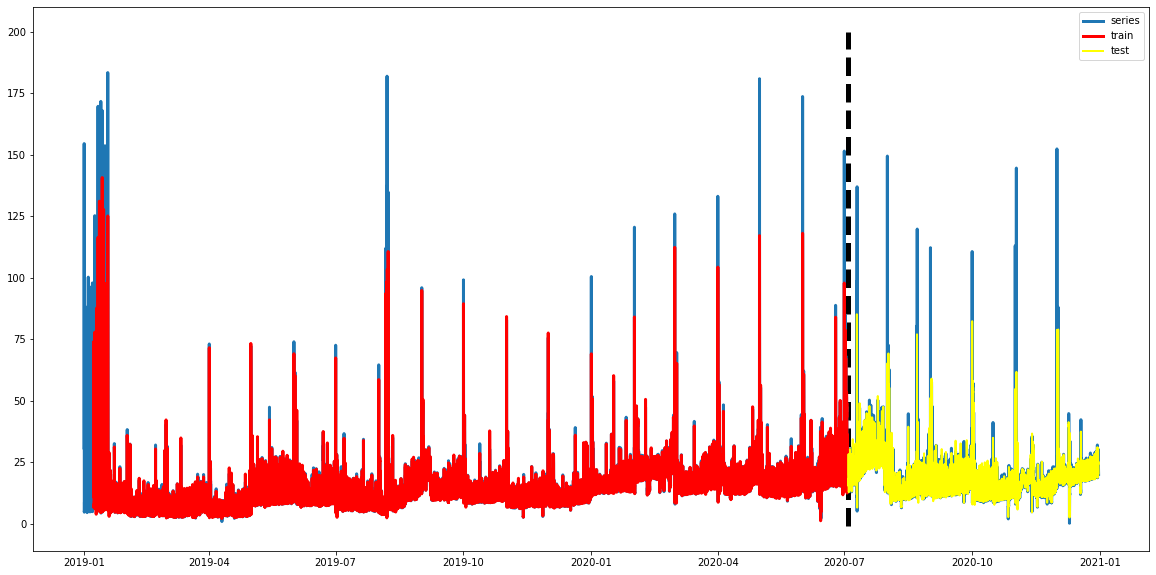

In [58]:
plt.figure(figsize=(20,10))
plt.plot(series,linewidth=3,label='series')
plt.vlines(X.index[-1440*6],-1,200,linestyles = "dashed",linewidth=5)
plt.plot(X.index[:-1440*6],trainpre,color='red',label='train',linewidth=3)
plt.plot(X.index[-1440*6:],preds,color='yellow',label='test', linewidth=2)
plt.legend()
plt.show()

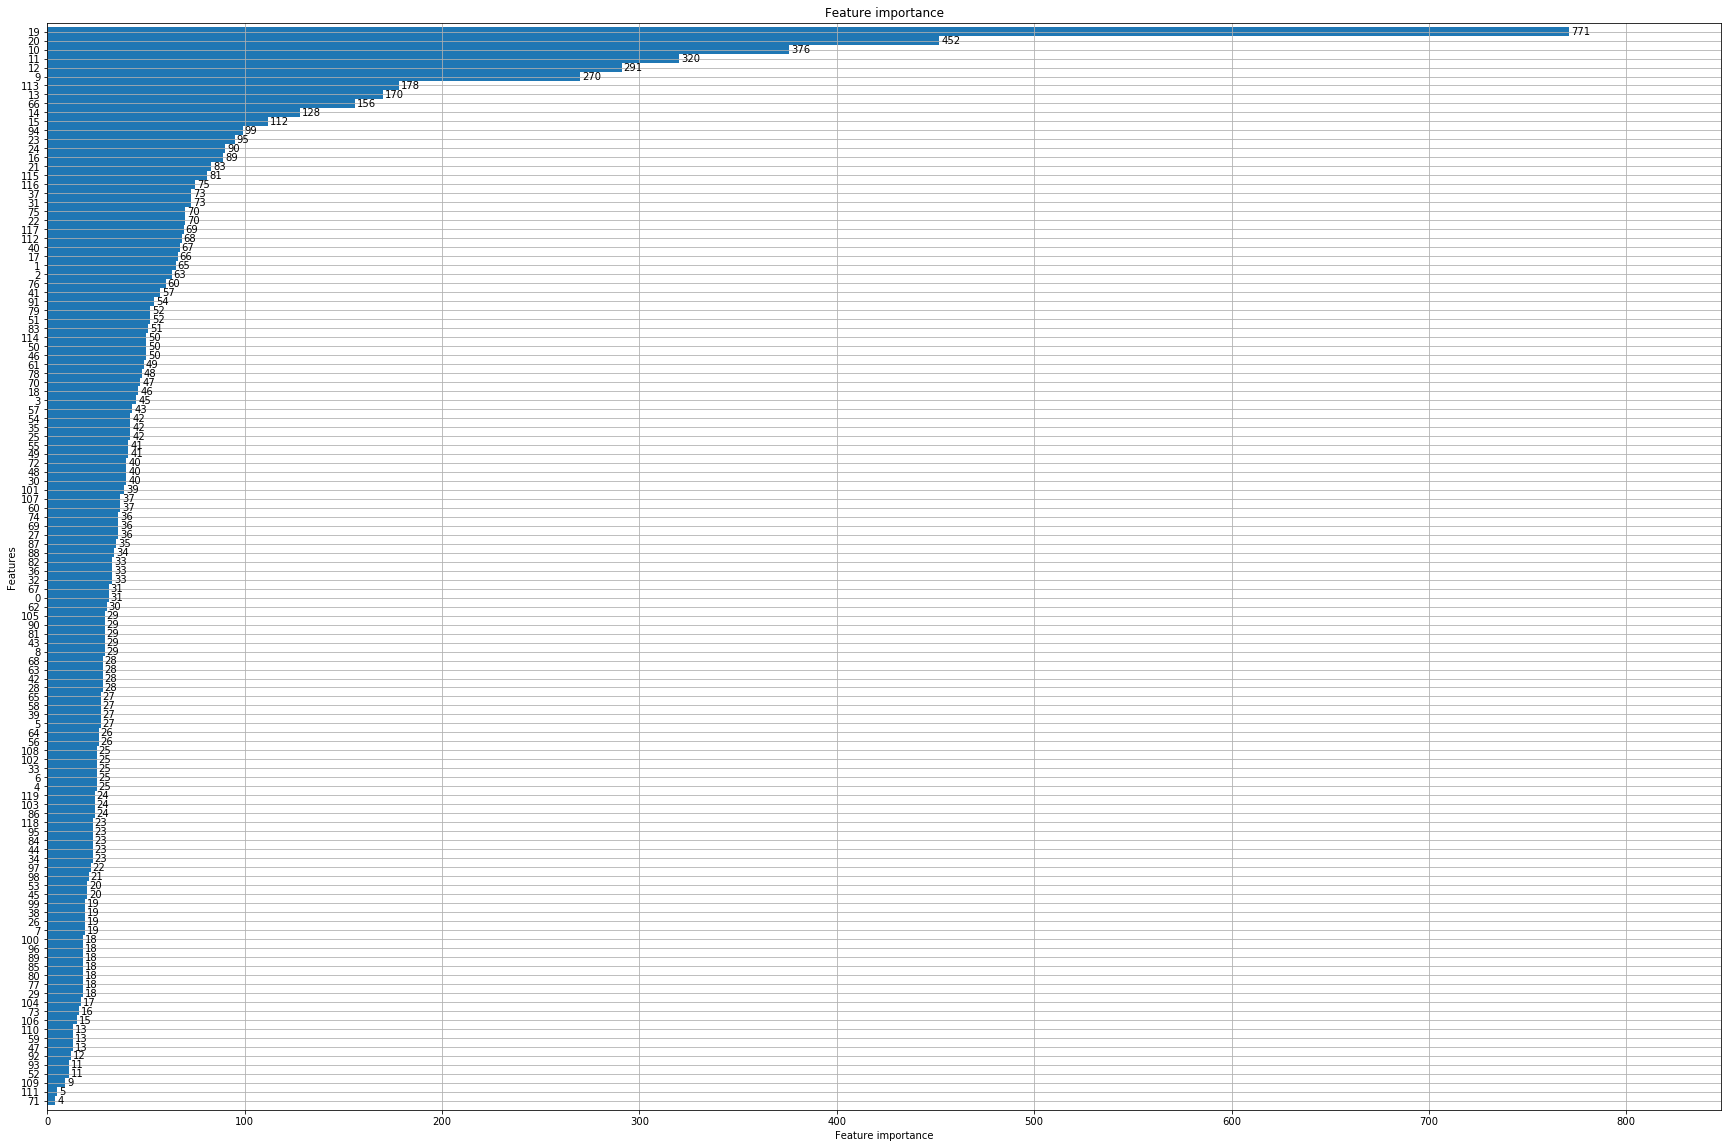

In [60]:
lgb.plot_importance(gbm,height=1,figsize=(30,20))
plt.show()

In [63]:
percent = np.percentile(gbm.feature_importance(),70)
features = [gbm.feature_name()[i] for i in np.where(gbm.feature_importance()>=percent)[0]]

In [64]:
[featurename[int(i)] for i in features]  #保留的特征，第14个是类别变量week

['1',
 '2',
 'max3',
 'min3',
 'var3',
 'median3',
 'max5',
 'min5',
 'var5',
 'median5',
 'var7',
 'diff1',
 'diff2',
 'lastweek_X',
 'week',
 'DB_TIME__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
 'DB_TIME__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
 'DB_TIME__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)',
 'DB_TIME__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
 'DB_TIME__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)',
 'DB_TIME__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)',
 'DB_TIME__quantile__q_0.9',
 'DB_TIME__fft_coefficient__attr_"abs"__coeff_17',
 'DB_TIME__fft_coefficient__attr_"abs"__coeff_15',
 'DB_TIME__last_location_of_maximum',
 'DB_TIME__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"',
 'DB_TIME__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"var"',
 'DB_TIME__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"min"',
 'DB_TIME__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"ma

In [67]:
X1 = X_new.iloc[:,np.where(gbm.feature_importance()>=percent)[0]]
#测试集6个月
X_train1 = X1[:-1440*6]
X_test1 = X1[-1440*6:]

In [76]:
def objective1(trial):
    dtrain1 = lgb.Dataset(X_train1, label=y_train,categorical_feature=[14])
    dvalid1 = lgb.Dataset(X_test1, label=y_test,categorical_feature=[14])
    
    param1 = {
        "objective": "regression",  #目标函数
        "metric": "rmse",  #评估函数
        "boosting_type": "gbdt",   #提升类型
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),   #叶子节点数
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),   #建树的特征选择比例
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),  #建树的样本采样比例
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),   # k意味着每k次迭代执行bagging
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse") #剪枝
    gbm1 = lgb.train(param1, dtrain1, valid_sets=[dvalid1],callbacks=[pruning_callback])
    preds1 = gbm1.predict(X_test1)
    rmse = mean_squared_error(y_test, preds1)**0.5
    return rmse

In [77]:
study1 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")  #优化方向RMSE最小
study1.optimize(objective1, n_trials=100, timeout=600) #100个trial或者600秒停止

print("Number of finished trials: ", len(study1.trials))
print("Best trial:")
trial1 = study1.best_trial

print("  Value: {}".format(trial1.value))
print("  Params: ")
for key, value in trial1.params.items():
    print("    {}: {}".format(key, value))

[I 2021-03-30 16:43:59,583] A new study created in memory with name: no-name-9a3d107d-b970-4875-99bb-e0a997c2bf36
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25283
[2]	valid_0's rmse: 7.62633
[3]	valid_0's rmse: 7.06581
[4]	valid_0's rmse: 6.57821
[5]	valid_0's rmse: 6.14883
[6]	valid_0's rmse: 5.79694
[7]	valid_0's rmse: 5.48107
[8]	valid_0's rmse: 5.19393
[9]	valid_0's rmse: 4.9797
[10]	valid_0's rmse: 4.79555
[11]	valid_0's rmse: 4.63368
[12]	valid_0's rmse: 4.48093
[13]	valid_0's rmse: 4.35754
[14]	valid_0's rmse: 4.25581
[15]	valid_0's rmse: 4.17285
[16]	valid_0's rmse: 4.1104
[17]	valid_0's rmse: 4.05774
[18]	valid_0's rmse: 4.0064
[19]	valid_0's rmse: 3.96986
[20]	valid_0's rmse: 3.93873
[21]	valid_0's rmse: 3.9153
[22]	valid_0's rmse: 3.89838
[23]	valid_0's rmse: 3.88558


[I 2021-03-30 16:44:00,672] Trial 0 finished with value: 3.7980195553950398 and parameters: {'lambda_l1': 3.363607480209882e-08, 'lambda_l2': 0.0003243464732101667, 'num_leaves': 105, 'feature_fraction': 0.49092836631971337, 'bagging_fraction': 0.7536289255759738, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 0 with value: 3.7980195553950398.


[96]	valid_0's rmse: 3.79808
[97]	valid_0's rmse: 3.79592
[98]	valid_0's rmse: 3.79417
[99]	valid_0's rmse: 3.79338
[100]	valid_0's rmse: 3.79802


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.29088
[2]	valid_0's rmse: 7.65251
[3]	valid_0's rmse: 7.11002
[4]	valid_0's rmse: 6.62858
[5]	valid_0's rmse: 6.19501
[6]	valid_0's rmse: 5.84576
[7]	valid_0's rmse: 5.54173
[8]	valid_0's rmse: 5.2687
[9]	valid_0's rmse: 5.07143
[10]	valid_0's rmse: 4.84945
[11]	valid_0's rmse: 4.6921
[12]	valid_0's rmse: 4.55355
[13]	valid_0's rmse: 4.4251
[14]	valid_0's rmse: 4.34826
[15]	valid_0's rmse: 4.26812
[16]	valid_0's rmse: 4.19153
[17]	valid_0's rmse: 4.09677
[18]	valid_0's rmse: 4.0106
[19]	valid_0's rmse: 3.9664
[20]	valid_0's rmse: 3.93206
[21]	valid_0's rmse: 3.89492
[22]	valid_0's rmse: 3.88607
[23]	valid_0's rmse: 3.85382
[

[I 2021-03-30 16:44:01,274] Trial 1 finished with value: 3.817143632041274 and parameters: {'lambda_l1': 1.1670954064310261e-08, 'lambda_l2': 0.20941398297853245, 'num_leaves': 51, 'feature_fraction': 0.5753842233063414, 'bagging_fraction': 0.4515713029677165, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 0 with value: 3.7980195553950398.


[83]	valid_0's rmse: 3.77341
[84]	valid_0's rmse: 3.7733
[85]	valid_0's rmse: 3.77458
[86]	valid_0's rmse: 3.78333
[87]	valid_0's rmse: 3.78571
[88]	valid_0's rmse: 3.78456
[89]	valid_0's rmse: 3.78545
[90]	valid_0's rmse: 3.78812
[91]	valid_0's rmse: 3.79439
[92]	valid_0's rmse: 3.79214
[93]	valid_0's rmse: 3.78968
[94]	valid_0's rmse: 3.79013
[95]	valid_0's rmse: 3.78842
[96]	valid_0's rmse: 3.79327
[97]	valid_0's rmse: 3.80094
[98]	valid_0's rmse: 3.80353
[99]	valid_0's rmse: 3.81378
[100]	valid_0's rmse: 3.81714


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28657
[2]	valid_0's rmse: 7.65171
[3]	valid_0's rmse: 7.09074
[4]	valid_0's rmse: 6.61962
[5]	valid_0's rmse: 6.17925
[6]	valid_0's rmse: 5.82283
[7]	valid_0's rmse: 5.51853
[8]	valid_0's rmse: 5.24636
[9]	valid_0's rmse: 5.01759
[10]	valid_0's rmse: 4.79888
[11]	valid_0's rmse: 4.65205
[12]	valid_0's rmse: 4.50692
[13]	valid_0's rmse: 4.35787
[14]	valid_0's rmse: 4.25733
[15]	valid_0's rmse: 4.18451
[16]	valid_0's rmse: 4.11746
[17]	valid_0's rmse: 4.06312
[18]	valid_0's rmse: 4.01324
[19]	valid_0's rmse: 3.97886
[20]	valid_0's rmse: 3.95208
[21]	valid_0's rmse: 3.92689
[22]	valid_0's rmse: 3.90142
[23]	valid_0's rmse: 3.88

[I 2021-03-30 16:44:01,941] Trial 2 finished with value: 3.7905393316218126 and parameters: {'lambda_l1': 0.01211516234316648, 'lambda_l2': 3.160715861695125, 'num_leaves': 48, 'feature_fraction': 0.5574265051748573, 'bagging_fraction': 0.819902236898832, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 2 with value: 3.7905393316218126.


[72]	valid_0's rmse: 3.77847
[73]	valid_0's rmse: 3.78165
[74]	valid_0's rmse: 3.7758
[75]	valid_0's rmse: 3.77328
[76]	valid_0's rmse: 3.77379
[77]	valid_0's rmse: 3.7731
[78]	valid_0's rmse: 3.77709
[79]	valid_0's rmse: 3.78005
[80]	valid_0's rmse: 3.779
[81]	valid_0's rmse: 3.77734
[82]	valid_0's rmse: 3.77924
[83]	valid_0's rmse: 3.78213
[84]	valid_0's rmse: 3.78019
[85]	valid_0's rmse: 3.77968
[86]	valid_0's rmse: 3.77771
[87]	valid_0's rmse: 3.78127
[88]	valid_0's rmse: 3.78162
[89]	valid_0's rmse: 3.78133
[90]	valid_0's rmse: 3.77955
[91]	valid_0's rmse: 3.78209
[92]	valid_0's rmse: 3.78149
[93]	valid_0's rmse: 3.78265
[94]	valid_0's rmse: 3.78788
[95]	valid_0's rmse: 3.78309
[96]	valid_0's rmse: 3.78359
[97]	valid_0's rmse: 3.78656
[98]	valid_0's rmse: 3.77917
[99]	valid_0's rmse: 3.78521
[100]	valid_0's rmse: 3.79054


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25368
[2]	valid_0's rmse: 7.60748
[3]	valid_0's rmse: 7.06139
[4]	valid_0's rmse: 6.5695
[5]	valid_0's rmse: 6.13706
[6]	valid_0's rmse: 5.78292
[7]	valid_0's rmse: 5.45407
[8]	valid_0's rmse: 5.18199
[9]	valid_0's rmse: 4.94823
[10]	valid_0's rmse: 4.74789
[11]	valid_0's rmse: 4.56834
[12]	valid_0's rmse: 4.42284
[13]	valid_0's rmse: 4.30518
[14]	valid_0's rmse: 4.21562
[15]	valid_0's rmse: 4.13249
[16]	valid_0's rmse: 4.07752
[17]	valid_0's rmse: 4.0362
[18]	valid_0's rmse: 4.00071
[19]	valid_0's rmse: 3.96773
[20]	valid_0's rmse: 3.94281
[21]	valid_0's rmse: 3.91854
[22]	valid_0's rmse: 3.91
[23]	valid_0's rmse: 3.88501
[

[I 2021-03-30 16:44:03,468] Trial 3 finished with value: 3.8619976505596445 and parameters: {'lambda_l1': 6.151364984767786e-07, 'lambda_l2': 7.575306359192882e-05, 'num_leaves': 165, 'feature_fraction': 0.5833180314512575, 'bagging_fraction': 0.5069939238457981, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 2 with value: 3.7905393316218126.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28745
[2]	valid_0's rmse: 7.66668
[3]	valid_0's rmse: 7.12535
[4]	valid_0's rmse: 6.67228
[5]	valid_0's rmse: 6.25458
[6]	valid_0's rmse: 5.87471
[7]	valid_0's rmse: 5.57179
[8]	valid_0's rmse: 5.31254
[9]	valid_0's rmse: 5.10124
[10]	valid_0's rmse: 4.90098
[11]	valid_0's rmse: 4.74591
[12]	valid_0's rmse: 4.62308
[13]	valid_0's rmse: 4.49788
[14]	valid_0's rmse: 4.40012
[15]	valid_0's rmse: 4.30417
[16]	valid_0's rmse: 4.23511
[17]	valid_0's rmse: 4.16737
[18]	valid_0's rmse: 4.12105
[19]	valid_0's rmse: 4.07081
[20]	valid_0's rmse: 4.02732
[21]	valid_0's rmse: 3.99648
[22]	valid_0's rmse: 3.95458
[23]	valid_0's rmse: 3.93

[I 2021-03-30 16:44:03,842] Trial 4 finished with value: 3.7568512943903225 and parameters: {'lambda_l1': 6.967102401212089e-08, 'lambda_l2': 6.745718073239708e-05, 'num_leaves': 19, 'feature_fraction': 0.5334899938672562, 'bagging_fraction': 0.6056556533304713, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 4 with value: 3.7568512943903225.


[77]	valid_0's rmse: 3.7442
[78]	valid_0's rmse: 3.74482
[79]	valid_0's rmse: 3.74059
[80]	valid_0's rmse: 3.74251
[81]	valid_0's rmse: 3.74747
[82]	valid_0's rmse: 3.75111
[83]	valid_0's rmse: 3.75423
[84]	valid_0's rmse: 3.75227
[85]	valid_0's rmse: 3.7508
[86]	valid_0's rmse: 3.74974
[87]	valid_0's rmse: 3.74536
[88]	valid_0's rmse: 3.74406
[89]	valid_0's rmse: 3.74701
[90]	valid_0's rmse: 3.75196
[91]	valid_0's rmse: 3.75321
[92]	valid_0's rmse: 3.75361
[93]	valid_0's rmse: 3.75463
[94]	valid_0's rmse: 3.75312
[95]	valid_0's rmse: 3.75285
[96]	valid_0's rmse: 3.75754
[97]	valid_0's rmse: 3.75542
[98]	valid_0's rmse: 3.75933
[99]	valid_0's rmse: 3.75239
[100]	valid_0's rmse: 3.75685
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-30 16:44:04,085] Trial 5 pruned. Trial was pruned at iteration 12.


[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25608
[2]	valid_0's rmse: 7.63032
[3]	valid_0's rmse: 7.06818
[4]	valid_0's rmse: 6.56723
[5]	valid_0's rmse: 6.1339
[6]	valid_0's rmse: 5.78368
[7]	valid_0's rmse: 5.48016
[8]	valid_0's rmse: 5.19378
[9]	valid_0's rmse: 4.9732
[10]	valid_0's rmse: 4.77222
[11]	valid_0's rmse: 4.61676
[12]	valid_0's rmse: 4.48062


[I 2021-03-30 16:44:04,407] Trial 6 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.23104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.57864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.01499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.54024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 6.12717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.76083
[LightGBM] [Warning] No further spli

[I 2021-03-30 16:44:04,687] Trial 7 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24342
[2]	valid_0's rmse: 7.62972
[3]	valid_0's rmse: 7.06396
[4]	valid_0's rmse: 6.54398
[5]	valid_0's rmse: 6.13174
[6]	valid_0's rmse: 5.78626
[7]	valid_0's rmse: 5.48786
[8]	valid_0's rmse: 5.22192
[9]	valid_0's rmse: 5.00051
[10]	valid_0's rmse: 4.80449
[11]	valid_0's rmse: 4.65027
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.13095

[I 2021-03-30 16:44:05,187] Trial 8 pruned. Trial was pruned at iteration 13.


[6]	valid_0's rmse: 5.7861
[7]	valid_0's rmse: 5.46505
[8]	valid_0's rmse: 5.1854
[9]	valid_0's rmse: 4.93961
[10]	valid_0's rmse: 4.76747
[11]	valid_0's rmse: 4.59316
[12]	valid_0's rmse: 4.46353
[13]	valid_0's rmse: 4.35528


[I 2021-03-30 16:44:05,421] Trial 9 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.27536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.6483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.05934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.55586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 6.14834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.78508
[LightGBM] [Warning] No further split

[I 2021-03-30 16:44:05,596] Trial 10 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.39139
[2]	valid_0's rmse: 7.83188
[3]	valid_0's rmse: 7.32354
[4]	valid_0's rmse: 6.88317
[5]	valid_0's rmse: 6.52668
[6]	valid_0's rmse: 6.20393
[7]	valid_0's rmse: 5.90841
[8]	valid_0's rmse: 5.63985
[9]	valid_0's rmse: 5.42515
[10]	valid_0's rmse: 5.21632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.29941

[I 2021-03-30 16:44:05,745] Trial 11 pruned. Trial was pruned at iteration 10.
[I 2021-03-30 16:44:05,925] Trial 12 pruned. Trial was pruned at iteration 12.


[10]	valid_0's rmse: 5.19055
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26606
[2]	valid_0's rmse: 7.62556
[3]	valid_0's rmse: 7.08134
[4]	valid_0's rmse: 6.60347
[5]	valid_0's rmse: 6.1841
[6]	valid_0's rmse: 5.81895
[7]	valid_0's rmse: 5.50607
[8]	valid_0's rmse: 5.2331
[9]	valid_0's rmse: 5.00148
[10]	valid_0's rmse: 4.7847
[11]	valid_0's rmse: 4.63185
[12]	valid_0's rmse: 4.48654


[I 2021-03-30 16:44:06,133] Trial 13 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25306
[2]	valid_0's rmse: 7.60906
[3]	valid_0's rmse: 7.07244
[4]	valid_0's rmse: 6.60573
[5]	valid_0's rmse: 6.20469
[6]	valid_0's rmse: 5.8539
[7]	valid_0's rmse: 5.4872
[8]	valid_0's rmse: 5.19495
[9]	valid_0's rmse: 4.96955
[10]	valid_0's rmse: 4.79752
[11]	valid_0's rmse: 4.6443
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-30 16:44:06,300] Trial 14 pruned. Trial was pruned at iteration 10.


[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26744
[2]	valid_0's rmse: 7.65541
[3]	valid_0's rmse: 7.1253
[4]	valid_0's rmse: 6.66394
[5]	valid_0's rmse: 6.25463
[6]	valid_0's rmse: 5.90501
[7]	valid_0's rmse: 5.58277
[8]	valid_0's rmse: 5.30821
[9]	valid_0's rmse: 5.08807
[10]	valid_0's rmse: 4.88542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27347
[2]	valid_0's rmse: 7.62733
[3]	valid_0's rmse: 7.08206
[4]	valid_0's rmse: 6.59405
[5]	valid_0's rmse: 6.16434
[6]	valid_0's rmse: 5.80304
[7]	valid_0's rmse: 5.463

[I 2021-03-30 16:44:07,636] Trial 15 finished with value: 3.768183418918583 and parameters: {'lambda_l1': 0.23182531619932256, 'lambda_l2': 2.050335541888139e-08, 'num_leaves': 79, 'feature_fraction': 0.8856187438165142, 'bagging_fraction': 0.8036829929494392, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 4 with value: 3.7568512943903225.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25054
[2]	valid_0's rmse: 7.60867
[3]	valid_0's rmse: 7.06285
[4]	valid_0's rmse: 6.60018
[5]	valid_0's rmse: 6.15995
[6]	valid_0's rmse: 5.81372
[7]	valid_0's rmse: 5.5138
[8]	valid_0's rmse: 5.25261
[9]	valid_0's rmse: 5.02031


[I 2021-03-30 16:44:07,991] Trial 16 pruned. Trial was pruned at iteration 10.


[10]	valid_0's rmse: 4.82171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2428
[2]	valid_0's rmse: 7.57631
[3]	valid_0's rmse: 7.03406


[I 2021-03-30 16:44:08,291] Trial 17 pruned. Trial was pruned at iteration 13.


[4]	valid_0's rmse: 6.57058
[5]	valid_0's rmse: 6.1524
[6]	valid_0's rmse: 5.78526
[7]	valid_0's rmse: 5.46738
[8]	valid_0's rmse: 5.19876
[9]	valid_0's rmse: 4.96538
[10]	valid_0's rmse: 4.76868
[11]	valid_0's rmse: 4.59965
[12]	valid_0's rmse: 4.4603
[13]	valid_0's rmse: 4.35289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26269
[2]	valid_0's rmse: 7.64067
[3]	valid_0's rmse: 7.06693
[4]	valid_0's rmse: 6.57517
[5]	valid_0's rmse: 6.1629
[6]	valid_0's rmse: 5.79955
[7]	valid_0's rmse: 5.4976
[8]	valid_0's rmse: 5.20915
[9]	valid_0's rmse: 4.985
[10]	valid_0's rmse: 4.78483
[11]	valid_0's rmse: 4.62933
[12]	valid_0's rmse: 4.49163
[13]	valid_0's rmse: 4.34979
[14]	val

[I 2021-03-30 16:44:08,630] Trial 18 pruned. Trial was pruned at iteration 17.


[15]	valid_0's rmse: 4.1704
[16]	valid_0's rmse: 4.10535
[17]	valid_0's rmse: 4.05033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25514
[2]	valid_0's rmse: 7.60256
[3]	valid_0's rmse: 7.05319
[4]	valid_0's rmse: 6.54891
[5]	valid_0's rmse: 6.14277
[6]	valid_0's rmse: 5.79187
[7]	valid_0's rmse: 5.49283
[8]	valid_0's rmse: 5.2113
[9]	valid_0's rmse: 4.98985
[10]	valid_0's rmse: 4.787
[11]	valid_0's rmse: 4.60623
[12]	valid_0's rmse: 4.46242
[13]	valid_0's rmse: 4.33328
[14]	valid_0's rmse: 4.23318
[15]	valid_0's rmse: 4.1581
[16]	valid_0's rmse: 4.0868
[17]	valid_0's rmse: 4.03303
[18]	valid_0's rmse: 3.96778
[19]	valid_0's rmse: 3.8848
[20]	valid_0's rmse: 3.84781
[21

[I 2021-03-30 16:44:09,587] Trial 19 finished with value: 3.7332178749111247 and parameters: {'lambda_l1': 5.747791582749586e-06, 'lambda_l2': 1.0344915264969313e-05, 'num_leaves': 76, 'feature_fraction': 0.8197513076683636, 'bagging_fraction': 0.6759532682102479, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 19 with value: 3.7332178749111247.
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-30 16:44:09,757] Trial 20 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.29176
[2]	valid_0's rmse: 7.63101
[3]	valid_0's rmse: 7.0672
[4]	valid_0's rmse: 6.59261
[5]	valid_0's rmse: 6.18654
[6]	valid_0's rmse: 5.84371
[7]	valid_0's rmse: 5.54937
[8]	valid_0's rmse: 5.26215
[9]	valid_0's rmse: 5.03372
[10]	valid_0's rmse: 4.83854
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25573


[I 2021-03-30 16:44:10,943] Trial 21 finished with value: 3.7054419102194136 and parameters: {'lambda_l1': 5.5116611210124836e-06, 'lambda_l2': 1.6272548634096205e-05, 'num_leaves': 73, 'feature_fraction': 0.8888294542720833, 'bagging_fraction': 0.6789562838859231, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 21 with value: 3.7054419102194136.


[100]	valid_0's rmse: 3.70544
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004700 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25126
[2]	valid_0's rmse: 7.58886
[3]	valid_0's rmse: 7.03635
[4]	valid_0's rmse: 6.55553
[5]	valid_0's rmse: 6.13237
[6]	valid_0's rmse: 5.75979
[7]	valid_0's rmse: 5.45236
[8]	valid_0's rmse: 5.18319
[9]	valid_0's rmse: 4.95267
[10]	valid_0's rmse: 4.74526
[11]	valid_0's rmse: 4.57435
[12]	valid_0's rmse: 4.43654
[13]	valid_0's rmse: 4.32615
[14]	valid_0's rmse: 4.23669
[15]	valid_0's rmse: 4.1477
[16]	valid_0's rmse: 4.08859
[17]	valid_0's rmse: 4.00364
[18]	valid_0's rmse: 3.93328
[19]	valid_0's rmse: 3.90043
[20]	valid_0's rmse: 3.87458
[21]	valid_0's rmse: 3.84553
[22]	valid_0's rmse: 3.82188
[23]	valid_0's rmse: 3.79809
[24]	valid_0's rmse: 3.78382
[25]	valid_0's rmse: 3.77088
[26]	valid_0's rmse: 3.75626
[27]	valid_0's rmse: 3.75039
[28]	valid_0's rmse: 3.7342
[29]	valid_0's rms

[I 2021-03-30 16:44:11,964] Trial 22 finished with value: 3.762173804113032 and parameters: {'lambda_l1': 1.0749816199430669e-05, 'lambda_l2': 2.8066582178294957e-05, 'num_leaves': 66, 'feature_fraction': 0.9705120982385478, 'bagging_fraction': 0.6725805312771876, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 21 with value: 3.7054419102194136.


[93]	valid_0's rmse: 3.77667
[94]	valid_0's rmse: 3.77319
[95]	valid_0's rmse: 3.77235
[96]	valid_0's rmse: 3.77189
[97]	valid_0's rmse: 3.76685
[98]	valid_0's rmse: 3.76265
[99]	valid_0's rmse: 3.75817
[100]	valid_0's rmse: 3.76217


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26184
[2]	valid_0's rmse: 7.63764
[3]	valid_0's rmse: 7.03635
[4]	valid_0's rmse: 6.55043
[5]	valid_0's rmse: 6.13383
[6]	valid_0's rmse: 5.77897
[7]	valid_0's rmse: 5.46047
[8]	valid_0's rmse: 5.16568
[9]	valid_0's rmse: 4.93284
[10]	valid_0's rmse: 4.74988
[11]	valid_0's rmse: 4.56096
[12]	valid_0's rmse: 4.4166
[13]	valid_0's rmse: 4.29659
[14]	valid_0's rmse: 4.20321
[15]	valid_0's rmse: 4.13306
[16]	valid_0's rmse: 4.07063
[17]	valid_0's rmse: 4.02882


[I 2021-03-30 16:44:12,450] Trial 23 pruned. Trial was pruned at iteration 35.


[18]	valid_0's rmse: 3.9558
[19]	valid_0's rmse: 3.92269
[20]	valid_0's rmse: 3.90916
[21]	valid_0's rmse: 3.87631
[22]	valid_0's rmse: 3.8491
[23]	valid_0's rmse: 3.83145
[24]	valid_0's rmse: 3.80955
[25]	valid_0's rmse: 3.79972
[26]	valid_0's rmse: 3.78278
[27]	valid_0's rmse: 3.77516
[28]	valid_0's rmse: 3.7759
[29]	valid_0's rmse: 3.76451
[30]	valid_0's rmse: 3.76175
[31]	valid_0's rmse: 3.76077
[32]	valid_0's rmse: 3.7682
[33]	valid_0's rmse: 3.75779
[34]	valid_0's rmse: 3.75885
[35]	valid_0's rmse: 3.76385


[I 2021-03-30 16:44:12,699] Trial 24 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27207
[2]	valid_0's rmse: 7.65459
[3]	valid_0's rmse: 7.1236
[4]	valid_0's rmse: 6.65712
[5]	valid_0's rmse: 6.24145
[6]	valid_0's rmse: 5.88937
[7]	valid_0's rmse: 5.56467
[8]	valid_0's rmse: 5.29833
[9]	valid_0's rmse: 5.08932
[10]	valid_0's rmse: 4.8718
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27263


[I 2021-03-30 16:44:12,912] Trial 25 pruned. Trial was pruned at iteration 12.


[2]	valid_0's rmse: 7.61234
[3]	valid_0's rmse: 7.05634
[4]	valid_0's rmse: 6.56769
[5]	valid_0's rmse: 6.14017
[6]	valid_0's rmse: 5.7715
[7]	valid_0's rmse: 5.4669
[8]	valid_0's rmse: 5.18237
[9]	valid_0's rmse: 4.92873
[10]	valid_0's rmse: 4.72003
[11]	valid_0's rmse: 4.58005
[12]	valid_0's rmse: 4.45267
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23167
[2]	valid_0's rmse: 7.59588
[3]	valid_0's rmse: 7.02109
[4]	valid_0's rmse: 6.53203
[5]	valid_0's rmse: 6.10268
[6]	valid_0's rmse: 5.71425
[7]	valid_0's rmse: 5.40731
[8]	valid_0's rmse: 5.13489
[9]	valid_0's rmse: 4.89813
[10]	valid_0's rmse: 4.70442
[11]	valid_0's rmse: 4.53051
[12]	valid_0's rmse: 4.3963
[13]	va

[I 2021-03-30 16:44:13,462] Trial 26 pruned. Trial was pruned at iteration 36.


[36]	valid_0's rmse: 3.76479
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2596
[2]	valid_0's rmse: 7.59754
[3]	valid_0's rmse: 7.04143
[4]	valid_0's rmse: 6.55522


[I 2021-03-30 16:44:13,703] Trial 27 pruned. Trial was pruned at iteration 12.


[5]	valid_0's rmse: 6.11671
[6]	valid_0's rmse: 5.73827
[7]	valid_0's rmse: 5.42494
[8]	valid_0's rmse: 5.14906
[9]	valid_0's rmse: 4.93328
[10]	valid_0's rmse: 4.742
[11]	valid_0's rmse: 4.58016
[12]	valid_0's rmse: 4.43788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-30 16:44:13,897] Trial 28 pruned. Trial was pruned at iteration 12.


[1]	valid_0's rmse: 8.23973
[2]	valid_0's rmse: 7.59393
[3]	valid_0's rmse: 7.00127
[4]	valid_0's rmse: 6.49539
[5]	valid_0's rmse: 6.09803
[6]	valid_0's rmse: 5.74905
[7]	valid_0's rmse: 5.41891
[8]	valid_0's rmse: 5.15034
[9]	valid_0's rmse: 4.92287
[10]	valid_0's rmse: 4.74037
[11]	valid_0's rmse: 4.59016
[12]	valid_0's rmse: 4.45716
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-30 16:44:14,128] Trial 29 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 8.26714
[2]	valid_0's rmse: 7.61111
[3]	valid_0's rmse: 7.04754
[4]	valid_0's rmse: 6.54245
[5]	valid_0's rmse: 6.12516
[6]	valid_0's rmse: 5.7667
[7]	valid_0's rmse: 5.4612
[8]	valid_0's rmse: 5.18625
[9]	valid_0's rmse: 4.9623
[10]	valid_0's rmse: 4.76709


[I 2021-03-30 16:44:14,377] Trial 30 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28252
[2]	valid_0's rmse: 7.62625
[3]	valid_0's rmse: 7.0685
[4]	valid_0's rmse: 6.59047
[5]	valid_0's rmse: 6.15007
[6]	valid_0's rmse: 5.78089
[7]	valid_0's rmse: 5.46239
[8]	valid_0's rmse: 5.19309
[9]	valid_0's rmse: 4.94653
[10]	valid_0's rmse: 4.74942
[11]	valid_0's rmse: 4.58549
[12]	valid_0's rmse: 4.43516
[13]	valid_0's rmse: 4.33204
[14]	valid_0's rmse: 4.23305


[I 2021-03-30 16:44:14,584] Trial 31 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25724
[2]	valid_0's rmse: 7.59285
[3]	valid_0's rmse: 7.04727
[4]	valid_0's rmse: 6.57313
[5]	valid_0's rmse: 6.1373
[6]	valid_0's rmse: 5.76873
[7]	valid_0's rmse: 5.46679
[8]	valid_0's rmse: 5.1945
[9]	valid_0's rmse: 4.95211
[10]	valid_0's rmse: 4.76879


[I 2021-03-30 16:44:14,784] Trial 32 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25823
[2]	valid_0's rmse: 7.58806
[3]	valid_0's rmse: 7.03652
[4]	valid_0's rmse: 6.55431
[5]	valid_0's rmse: 6.12074
[6]	valid_0's rmse: 5.74625
[7]	valid_0's rmse: 5.42489
[8]	valid_0's rmse: 5.17115
[9]	valid_0's rmse: 4.941
[10]	valid_0's rmse: 4.75561


[I 2021-03-30 16:44:15,005] Trial 33 pruned. Trial was pruned at iteration 12.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26976
[2]	valid_0's rmse: 7.63797
[3]	valid_0's rmse: 7.07118
[4]	valid_0's rmse: 6.58801
[5]	valid_0's rmse: 6.14969
[6]	valid_0's rmse: 5.78292
[7]	valid_0's rmse: 5.45757
[8]	valid_0's rmse: 5.18245
[9]	valid_0's rmse: 4.95065
[10]	valid_0's rmse: 4.75252
[11]	valid_0's rmse: 4.5909
[12]	valid_0's rmse: 4.45227


[I 2021-03-30 16:44:15,149] Trial 34 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.64173
[2]	valid_0's rmse: 8.28387
[3]	valid_0's rmse: 7.88901
[4]	valid_0's rmse: 7.66703
[5]	valid_0's rmse: 7.30863
[6]	valid_0's rmse: 7.14764
[7]	valid_0's rmse: 6.80051
[8]	valid_0's rmse: 6.65841
[9]	valid_0's rmse: 6.35096
[10]	valid_0's rmse: 6.25787
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25111

[I 2021-03-30 16:44:15,344] Trial 35 pruned. Trial was pruned at iteration 12.


[7]	valid_0's rmse: 5.47167
[8]	valid_0's rmse: 5.20268
[9]	valid_0's rmse: 4.95901
[10]	valid_0's rmse: 4.76251
[11]	valid_0's rmse: 4.59084
[12]	valid_0's rmse: 4.44986
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28298
[2]	valid_0's rmse: 7.64822
[3]	valid_0's rmse: 7.09028
[4]	valid_0's rmse: 6.60236
[5]	valid_0's rmse: 6.18447


[I 2021-03-30 16:44:15,513] Trial 36 pruned. Trial was pruned at iteration 10.


[6]	valid_0's rmse: 5.79137
[7]	valid_0's rmse: 5.48007
[8]	valid_0's rmse: 5.2073
[9]	valid_0's rmse: 4.97799
[10]	valid_0's rmse: 4.77585
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24077
[2]	valid_0's rmse: 7.57928
[3]	valid_0's rmse: 6.99638
[4]	valid_0's rmse: 6.49779


[I 2021-03-30 16:44:15,764] Trial 37 pruned. Trial was pruned at iteration 14.


[5]	valid_0's rmse: 6.09874
[6]	valid_0's rmse: 5.74517
[7]	valid_0's rmse: 5.43681
[8]	valid_0's rmse: 5.16445
[9]	valid_0's rmse: 4.92495
[10]	valid_0's rmse: 4.74402
[11]	valid_0's rmse: 4.57529
[12]	valid_0's rmse: 4.43589
[13]	valid_0's rmse: 4.31423
[14]	valid_0's rmse: 4.22678


[I 2021-03-30 16:44:16,040] Trial 38 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26324
[2]	valid_0's rmse: 7.60833
[3]	valid_0's rmse: 7.05611
[4]	valid_0's rmse: 6.58192
[5]	valid_0's rmse: 6.16742
[6]	valid_0's rmse: 5.78928
[7]	valid_0's rmse: 5.46332
[8]	valid_0's rmse: 5.15829
[9]	valid_0's rmse: 4.94941
[10]	valid_0's rmse: 4.76312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-30 16:44:16,273] Trial 39 pruned. Trial was pruned at iteration 13.


[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.21212
[2]	valid_0's rmse: 7.57307
[3]	valid_0's rmse: 6.99507
[4]	valid_0's rmse: 6.50246
[5]	valid_0's rmse: 6.09651
[6]	valid_0's rmse: 5.70338
[7]	valid_0's rmse: 5.39092
[8]	valid_0's rmse: 5.13392
[9]	valid_0's rmse: 4.91515
[10]	valid_0's rmse: 4.74065
[11]	valid_0's rmse: 4.57819
[12]	valid_0's rmse: 4.44518
[13]	valid_0's rmse: 4.32881


[I 2021-03-30 16:44:16,422] Trial 40 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.29867
[2]	valid_0's rmse: 7.64088
[3]	valid_0's rmse: 7.09705
[4]	valid_0's rmse: 6.62538
[5]	valid_0's rmse: 6.24565
[6]	valid_0's rmse: 5.91496
[7]	valid_0's rmse: 5.6155
[8]	valid_0's rmse: 5.35211
[9]	valid_0's rmse: 5.12133
[10]	valid_0's rmse: 4.9036
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-30 16:44:16,647] Trial 41 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 8.27218
[2]	valid_0's rmse: 7.63467
[3]	valid_0's rmse: 7.07183
[4]	valid_0's rmse: 6.56052
[5]	valid_0's rmse: 6.13239
[6]	valid_0's rmse: 5.76003
[7]	valid_0's rmse: 5.45069
[8]	valid_0's rmse: 5.19105
[9]	valid_0's rmse: 4.97573
[10]	valid_0's rmse: 4.77918
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006047 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-30 16:44:16,890] Trial 42 pruned. Trial was pruned at iteration 15.


[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25874
[2]	valid_0's rmse: 7.60061
[3]	valid_0's rmse: 7.01524
[4]	valid_0's rmse: 6.51816
[5]	valid_0's rmse: 6.09003
[6]	valid_0's rmse: 5.74805
[7]	valid_0's rmse: 5.44437
[8]	valid_0's rmse: 5.14649
[9]	valid_0's rmse: 4.92637
[10]	valid_0's rmse: 4.73407
[11]	valid_0's rmse: 4.56355
[12]	valid_0's rmse: 4.43093
[13]	valid_0's rmse: 4.32114
[14]	valid_0's rmse: 4.23251
[15]	valid_0's rmse: 4.15582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2514
[2]	valid_0's rmse: 

[I 2021-03-30 16:44:17,209] Trial 43 pruned. Trial was pruned at iteration 20.
[I 2021-03-30 16:44:17,414] Trial 44 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27348
[2]	valid_0's rmse: 7.61815
[3]	valid_0's rmse: 7.08486
[4]	valid_0's rmse: 6.59072
[5]	valid_0's rmse: 6.13015
[6]	valid_0's rmse: 5.75301
[7]	valid_0's rmse: 5.43002
[8]	valid_0's rmse: 5.17652
[9]	valid_0's rmse: 4.95461
[10]	valid_0's rmse: 4.77902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005325 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-30 16:44:17,712] Trial 45 pruned. Trial was pruned at iteration 16.


[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24761
[2]	valid_0's rmse: 7.61114
[3]	valid_0's rmse: 7.04534
[4]	valid_0's rmse: 6.56821
[5]	valid_0's rmse: 6.13169
[6]	valid_0's rmse: 5.77957
[7]	valid_0's rmse: 5.47682
[8]	valid_0's rmse: 5.18835
[9]	valid_0's rmse: 4.9682
[10]	valid_0's rmse: 4.76494
[11]	valid_0's rmse: 4.5863
[12]	valid_0's rmse: 4.44357
[13]	valid_0's rmse: 4.32527
[14]	valid_0's rmse: 4.23515
[15]	valid_0's rmse: 4.15325
[16]	valid_0's rmse: 4.08931


[I 2021-03-30 16:44:17,939] Trial 46 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23741
[2]	valid_0's rmse: 7.58022
[3]	valid_0's rmse: 7.02522
[4]	valid_0's rmse: 6.54671
[5]	valid_0's rmse: 6.11635
[6]	valid_0's rmse: 5.75117
[7]	valid_0's rmse: 5.45453
[8]	valid_0's rmse: 5.20719
[9]	valid_0's rmse: 4.99755
[10]	valid_0's rmse: 4.81281
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25493

[I 2021-03-30 16:44:19,607] Trial 47 finished with value: 3.727467148346146 and parameters: {'lambda_l1': 0.10923654905166062, 'lambda_l2': 3.8088777720796385e-05, 'num_leaves': 160, 'feature_fraction': 0.7997476046210139, 'bagging_fraction': 0.6640838090981793, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 21 with value: 3.7054419102194136.


[98]	valid_0's rmse: 3.72377
[99]	valid_0's rmse: 3.72452
[100]	valid_0's rmse: 3.72747


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28229
[2]	valid_0's rmse: 7.61957
[3]	valid_0's rmse: 7.04424
[4]	valid_0's rmse: 6.54639
[5]	valid_0's rmse: 6.12575
[6]	valid_0's rmse: 5.76499
[7]	valid_0's rmse: 5.46592
[8]	valid_0's rmse: 5.17942
[9]	valid_0's rmse: 4.95393
[10]	valid_0's rmse: 4.75041
[11]	valid_0's rmse: 4.56667
[12]	valid_0's rmse: 4.42859
[13]	valid_0's rmse: 4.31138
[14]	valid_0's rmse: 4.20322
[15]	valid_0's rmse: 4.1266
[16]	valid_0's rmse: 4.06277


[I 2021-03-30 16:44:19,961] Trial 48 pruned. Trial was pruned at iteration 19.


[17]	valid_0's rmse: 4.01649
[18]	valid_0's rmse: 3.98279
[19]	valid_0's rmse: 3.94401
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24083
[2]	valid_0's rmse: 7.58353
[3]	valid_0's rmse: 6.9974
[4]	valid_0's rmse: 6.50238
[5]	valid_0's rmse: 6.08956
[6]	valid_0's rmse: 5.73753
[7]	valid_0's rmse: 5.44471
[8]	valid_0's rmse: 5.16857
[9]	valid_0's rmse: 4.93915
[10]	valid_0's rmse: 4.73604
[11]	valid_0's rmse: 4.56426
[12]	valid_0's rmse: 4.42416
[13]	valid_0's rmse: 4.30227
[14]	valid_0's rmse: 4.20561
[15]	valid_0's rmse: 4.13754
[16]	valid_0's rmse: 4.06927
[17]	valid_0's rmse: 4.01105
[18]	valid_0's rmse: 3.94353
[19]	valid_0's rmse: 3.89839
[20]	valid_0's rmse: 3.872

[I 2021-03-30 16:44:21,474] Trial 49 finished with value: 3.6583771474345785 and parameters: {'lambda_l1': 0.03723787920152494, 'lambda_l2': 7.37084698329998e-06, 'num_leaves': 147, 'feature_fraction': 0.7232885892351055, 'bagging_fraction': 0.653615223411343, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 49 with value: 3.6583771474345785.



[99]	valid_0's rmse: 3.65658
[100]	valid_0's rmse: 3.65838


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-30 16:44:21,728] Trial 50 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23457
[2]	valid_0's rmse: 7.57903
[3]	valid_0's rmse: 7.02213
[4]	valid_0's rmse: 6.54768
[5]	valid_0's rmse: 6.14198
[6]	valid_0's rmse: 5.79399
[7]	valid_0's rmse: 5.49055
[8]	valid_0's rmse: 5.21171
[9]	valid_0's rmse: 4.9866
[10]	valid_0's rmse: 4.78334


[I 2021-03-30 16:44:22,011] Trial 51 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24458
[2]	valid_0's rmse: 7.62057
[3]	valid_0's rmse: 7.01833
[4]	valid_0's rmse: 6.5254
[5]	valid_0's rmse: 6.11956
[6]	valid_0's rmse: 5.76354
[7]	valid_0's rmse: 5.46974
[8]	valid_0's rmse: 5.18106
[9]	valid_0's rmse: 4.95915
[10]	valid_0's rmse: 4.76435
[11]	valid_0's rmse: 4.58499


[I 2021-03-30 16:44:22,299] Trial 52 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25697
[2]	valid_0's rmse: 7.58805
[3]	valid_0's rmse: 7.01203
[4]	valid_0's rmse: 6.55237
[5]	valid_0's rmse: 6.11985
[6]	valid_0's rmse: 5.73839
[7]	valid_0's rmse: 5.42048
[8]	valid_0's rmse: 5.1453
[9]	valid_0's rmse: 4.93172
[10]	valid_0's rmse: 4.72164
[11]	valid_0's rmse: 4.56853


[I 2021-03-30 16:44:22,547] Trial 53 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.26785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.61254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.0611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.56253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 6.14629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.79157
[LightGBM] [Warning] No further split

[I 2021-03-30 16:44:23,119] Trial 54 pruned. Trial was pruned at iteration 31.


[29]	valid_0's rmse: 3.74146
[30]	valid_0's rmse: 3.7388
[31]	valid_0's rmse: 3.74098
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955


[I 2021-03-30 16:44:23,453] Trial 55 pruned. Trial was pruned at iteration 10.


[1]	valid_0's rmse: 8.24585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.60539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.06231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.59031
[5]	valid_0's rmse: 6.15261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.76756
[7]	valid_0's rmse: 5.47387
[8]	valid_0's rmse: 5.19565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's rmse: 4.97503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 4.7715


[I 2021-03-30 16:44:23,669] Trial 56 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 8.28942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7.66676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7.12561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.60346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 6.17266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 5.78492
[LightGBM] [Warning] No further spli

[I 2021-03-30 16:44:23,916] Trial 57 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25984
[2]	valid_0's rmse: 7.59986
[3]	valid_0's rmse: 7.03061
[4]	valid_0's rmse: 6.55373
[5]	valid_0's rmse: 6.13915
[6]	valid_0's rmse: 5.79273
[7]	valid_0's rmse: 5.46586
[8]	valid_0's rmse: 5.18771
[9]	valid_0's rmse: 4.95611
[10]	valid_0's rmse: 4.75488
[11]	valid_0's rmse: 4.58348
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.13095

[I 2021-03-30 16:44:25,361] Trial 58 finished with value: 3.660946068843947 and parameters: {'lambda_l1': 0.00023759364042375502, 'lambda_l2': 5.640643152730009e-05, 'num_leaves': 166, 'feature_fraction': 0.6241412479836946, 'bagging_fraction': 0.6496769318839282, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 49 with value: 3.6583771474345785.


[96]	valid_0's rmse: 3.65616
[97]	valid_0's rmse: 3.65233
[98]	valid_0's rmse: 3.65752
[99]	valid_0's rmse: 3.65805
[100]	valid_0's rmse: 3.66095


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24645
[2]	valid_0's rmse: 7.60152
[3]	valid_0's rmse: 7.02419
[4]	valid_0's rmse: 6.5221
[5]	valid_0's rmse: 6.11303
[6]	valid_0's rmse: 5.76138
[7]	valid_0's rmse: 5.44283
[8]	valid_0's rmse: 5.16825
[9]	valid_0's rmse: 4.93974
[10]	valid_0's rmse: 4.73879
[11]	valid_0's rmse: 4.56551
[12]	valid_0's rmse: 4.42534
[13]	valid_0's rmse: 4.28802
[14]	valid_0's rmse: 4.19314
[15]	valid_0's rmse: 4.12285


[I 2021-03-30 16:44:25,867] Trial 59 pruned. Trial was pruned at iteration 29.


[16]	valid_0's rmse: 4.05468
[17]	valid_0's rmse: 4.00977
[18]	valid_0's rmse: 3.94783
[19]	valid_0's rmse: 3.9079
[20]	valid_0's rmse: 3.87121
[21]	valid_0's rmse: 3.84523
[22]	valid_0's rmse: 3.82103
[23]	valid_0's rmse: 3.8062
[24]	valid_0's rmse: 3.76579
[25]	valid_0's rmse: 3.76359
[26]	valid_0's rmse: 3.75599
[27]	valid_0's rmse: 3.75998
[28]	valid_0's rmse: 3.7587
[29]	valid_0's rmse: 3.75126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25284
[2]	valid_0's rmse: 7.60066
[3]	valid_0's rmse: 7.01906
[4]	valid_0's rmse: 6.50257
[5]	valid_0's rmse: 6.08138
[6]	valid_0's rmse: 5.73752
[7]	valid_0's rmse: 5.41963
[8]	valid_0's rmse: 5.14436
[9]	valid_0's rmse: 4.92353

[I 2021-03-30 16:44:26,329] Trial 60 pruned. Trial was pruned at iteration 17.


[10]	valid_0's rmse: 4.71838
[11]	valid_0's rmse: 4.57237
[12]	valid_0's rmse: 4.43282
[13]	valid_0's rmse: 4.29976
[14]	valid_0's rmse: 4.19637
[15]	valid_0's rmse: 4.1262
[16]	valid_0's rmse: 4.06764
[17]	valid_0's rmse: 4.0242
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23452
[2]	valid_0's rmse: 7.58676
[3]	valid_0's rmse: 7.02838
[4]	valid_0's rmse: 6.53261
[5]	valid_0's rmse: 6.11663
[6]	valid_0's rmse: 5.75927
[7]	valid_0's rmse: 5.45176
[8]	valid_0's rmse: 5.16552
[9]	valid_0's rmse: 4.93645
[10]	valid_0's rmse: 4.73552
[11]	valid_0's rmse: 4.55749
[12]	valid_0's rmse: 4.41886
[13]	valid_0's rmse: 4.2953
[14]	valid_0's rmse: 4.19074
[15]	valid_0's rmse: 4.10858

[I 2021-03-30 16:44:27,799] Trial 61 finished with value: 3.7137604751345314 and parameters: {'lambda_l1': 0.0001433386760262838, 'lambda_l2': 3.933944163182976e-05, 'num_leaves': 152, 'feature_fraction': 0.6694305164734976, 'bagging_fraction': 0.6885959797811116, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 49 with value: 3.6583771474345785.


[98]	valid_0's rmse: 3.71815
[99]	valid_0's rmse: 3.71402
[100]	valid_0's rmse: 3.71376


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24389
[2]	valid_0's rmse: 7.59741
[3]	valid_0's rmse: 7.03439
[4]	valid_0's rmse: 6.53025
[5]	valid_0's rmse: 6.11265
[6]	valid_0's rmse: 5.75345
[7]	valid_0's rmse: 5.44575
[8]	valid_0's rmse: 5.16713
[9]	valid_0's rmse: 4.94681
[10]	valid_0's rmse: 4.73851
[11]	valid_0's rmse: 4.56339
[12]	valid_0's rmse: 4.4176
[13]	valid_0's rmse: 4.30334
[14]	valid_0's rmse: 4.20543
[15]	valid_0's rmse: 4.13002


[I 2021-03-30 16:44:28,299] Trial 62 pruned. Trial was pruned at iteration 27.


[16]	valid_0's rmse: 4.06592
[17]	valid_0's rmse: 4.01771
[18]	valid_0's rmse: 3.93276
[19]	valid_0's rmse: 3.88544
[20]	valid_0's rmse: 3.84506
[21]	valid_0's rmse: 3.81825
[22]	valid_0's rmse: 3.79539
[23]	valid_0's rmse: 3.77846
[24]	valid_0's rmse: 3.77137
[25]	valid_0's rmse: 3.75882
[26]	valid_0's rmse: 3.75432
[27]	valid_0's rmse: 3.76008


[I 2021-03-30 16:44:28,588] Trial 63 pruned. Trial was pruned at iteration 17.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25999
[2]	valid_0's rmse: 7.59957
[3]	valid_0's rmse: 7.02717
[4]	valid_0's rmse: 6.50759
[5]	valid_0's rmse: 6.0883
[6]	valid_0's rmse: 5.7069
[7]	valid_0's rmse: 5.39805
[8]	valid_0's rmse: 5.1203
[9]	valid_0's rmse: 4.90129
[10]	valid_0's rmse: 4.7042
[11]	valid_0's rmse: 4.53991
[12]	valid_0's rmse: 4.40173
[13]	valid_0's rmse: 4.2923
[14]	valid_0's rmse: 4.20948
[15]	valid_0's rmse: 4.13336
[16]	valid_0's rmse: 4.07322
[17]	valid_0's rmse: 4.02533


[I 2021-03-30 16:44:28,826] Trial 64 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26039
[2]	valid_0's rmse: 7.5924
[3]	valid_0's rmse: 7.03845
[4]	valid_0's rmse: 6.5288
[5]	valid_0's rmse: 6.12625
[6]	valid_0's rmse: 5.77392
[7]	valid_0's rmse: 5.45323
[8]	valid_0's rmse: 5.1805
[9]	valid_0's rmse: 4.95916
[10]	valid_0's rmse: 4.75343
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24439
[2

[I 2021-03-30 16:44:29,216] Trial 65 pruned. Trial was pruned at iteration 17.


[13]	valid_0's rmse: 4.29064
[14]	valid_0's rmse: 4.211
[15]	valid_0's rmse: 4.13698
[16]	valid_0's rmse: 4.07078
[17]	valid_0's rmse: 4.02919
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24219
[2]	valid_0's rmse: 7.57845
[3]	valid_0's rmse: 7.0193
[4]	valid_0's rmse: 6.54408
[5]	valid_0's rmse: 6.10827
[6]	valid_0's rmse: 5.72662
[7]	valid_0's rmse: 5.40812
[8]	valid_0's rmse: 5.13163
[9]	valid_0's rmse: 4.90284
[10]	valid_0's rmse: 4.70119
[11]	valid_0's rmse: 4.52665
[12]	valid_0's rmse: 4.39331
[13]	valid_0's rmse: 4.27825


[I 2021-03-30 16:44:29,704] Trial 66 pruned. Trial was pruned at iteration 24.


[14]	valid_0's rmse: 4.17722
[15]	valid_0's rmse: 4.09622
[16]	valid_0's rmse: 4.04045
[17]	valid_0's rmse: 3.99342
[18]	valid_0's rmse: 3.96169
[19]	valid_0's rmse: 3.91864
[20]	valid_0's rmse: 3.88369
[21]	valid_0's rmse: 3.849
[22]	valid_0's rmse: 3.8298
[23]	valid_0's rmse: 3.8025
[24]	valid_0's rmse: 3.79669


[I 2021-03-30 16:44:29,968] Trial 67 pruned. Trial was pruned at iteration 12.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25023
[2]	valid_0's rmse: 7.61052
[3]	valid_0's rmse: 7.01187
[4]	valid_0's rmse: 6.5305
[5]	valid_0's rmse: 6.09639
[6]	valid_0's rmse: 5.7307
[7]	valid_0's rmse: 5.41574
[8]	valid_0's rmse: 5.15327
[9]	valid_0's rmse: 4.93252
[10]	valid_0's rmse: 4.72676
[11]	valid_0's rmse: 4.56704
[12]	valid_0's rmse: 4.43178


[I 2021-03-30 16:44:30,180] Trial 68 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25938
[2]	valid_0's rmse: 7.62598
[3]	valid_0's rmse: 7.07004
[4]	valid_0's rmse: 6.5745
[5]	valid_0's rmse: 6.16159
[6]	valid_0's rmse: 5.8098
[7]	valid_0's rmse: 5.48871
[8]	valid_0's rmse: 5.20547
[9]	valid_0's rmse: 4.969
[10]	valid_0's rmse: 4.79096


[I 2021-03-30 16:44:30,413] Trial 69 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25226
[2]	valid_0's rmse: 7.61273
[3]	valid_0's rmse: 7.05402
[4]	valid_0's rmse: 6.57486
[5]	valid_0's rmse: 6.15254
[6]	valid_0's rmse: 5.79584
[7]	valid_0's rmse: 5.49437
[8]	valid_0's rmse: 5.23017
[9]	valid_0's rmse: 5.01827
[10]	valid_0's rmse: 4.81101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25842

[I 2021-03-30 16:44:30,735] Trial 70 pruned. Trial was pruned at iteration 17.


[17]	valid_0's rmse: 4.00113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26592
[2]	valid_0's rmse: 7.63018


[I 2021-03-30 16:44:31,112] Trial 71 pruned. Trial was pruned at iteration 18.


[3]	valid_0's rmse: 7.06717
[4]	valid_0's rmse: 6.58157
[5]	valid_0's rmse: 6.1472
[6]	valid_0's rmse: 5.7664
[7]	valid_0's rmse: 5.45327
[8]	valid_0's rmse: 5.17914
[9]	valid_0's rmse: 4.94769
[10]	valid_0's rmse: 4.74398
[11]	valid_0's rmse: 4.57491
[12]	valid_0's rmse: 4.4317
[13]	valid_0's rmse: 4.3066
[14]	valid_0's rmse: 4.20488
[15]	valid_0's rmse: 4.11233
[16]	valid_0's rmse: 4.05367
[17]	valid_0's rmse: 4.00316
[18]	valid_0's rmse: 3.96122


[I 2021-03-30 16:44:31,335] Trial 72 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26904
[2]	valid_0's rmse: 7.64585
[3]	valid_0's rmse: 7.09451
[4]	valid_0's rmse: 6.60664
[5]	valid_0's rmse: 6.17082
[6]	valid_0's rmse: 5.79565
[7]	valid_0's rmse: 5.47627
[8]	valid_0's rmse: 5.17741
[9]	valid_0's rmse: 4.96222
[10]	valid_0's rmse: 4.76516


[I 2021-03-30 16:44:31,600] Trial 73 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25783
[2]	valid_0's rmse: 7.58512
[3]	valid_0's rmse: 7.0056
[4]	valid_0's rmse: 6.52715
[5]	valid_0's rmse: 6.10678
[6]	valid_0's rmse: 5.74826
[7]	valid_0's rmse: 5.41938
[8]	valid_0's rmse: 5.13852
[9]	valid_0's rmse: 4.90112
[10]	valid_0's rmse: 4.71117
[11]	valid_0's rmse: 4.56188
[12]	valid_0's rmse: 4.42732
[13]	valid_0's rmse: 4.31883
[14]	valid_0's rmse: 4.2225


[I 2021-03-30 16:44:31,756] Trial 74 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.29921
[2]	valid_0's rmse: 7.68445
[3]	valid_0's rmse: 7.18466
[4]	valid_0's rmse: 6.75803
[5]	valid_0's rmse: 6.35605
[6]	valid_0's rmse: 5.98193
[7]	valid_0's rmse: 5.65952
[8]	valid_0's rmse: 5.37659
[9]	valid_0's rmse: 5.15813
[10]	valid_0's rmse: 4.96172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2469


[I 2021-03-30 16:44:31,971] Trial 75 pruned. Trial was pruned at iteration 10.


[3]	valid_0's rmse: 7.0748
[4]	valid_0's rmse: 6.58804
[5]	valid_0's rmse: 6.15806
[6]	valid_0's rmse: 5.78745
[7]	valid_0's rmse: 5.45941
[8]	valid_0's rmse: 5.1784
[9]	valid_0's rmse: 4.95441
[10]	valid_0's rmse: 4.76227
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24254
[2]	valid_0's rmse: 7.57463
[3]	valid_0's rmse: 7.01203
[4]	valid_0's rmse: 6.52871
[5]	valid_0's rmse: 6.11127
[6]	valid_0's rmse: 5.72563
[7]	valid_0's rmse: 5.42472
[8]	valid_0's rmse: 5.15178
[9]	valid_0's rmse: 4.92526
[10]	valid_0's rmse: 4.7269
[11]	valid_0's rmse: 4.54767
[12]	valid_0's rmse: 4.39765
[13]	valid_0's rmse: 4.28242
[14]	valid_0's rmse: 4.18498
[15]	valid_0's rmse: 4.11901
[16]	v

[I 2021-03-30 16:44:32,384] Trial 76 pruned. Trial was pruned at iteration 27.


[18]	valid_0's rmse: 3.95831
[19]	valid_0's rmse: 3.87075
[20]	valid_0's rmse: 3.84493
[21]	valid_0's rmse: 3.81209
[22]	valid_0's rmse: 3.79438
[23]	valid_0's rmse: 3.7803
[24]	valid_0's rmse: 3.77384
[25]	valid_0's rmse: 3.76368
[26]	valid_0's rmse: 3.75886
[27]	valid_0's rmse: 3.76374


[I 2021-03-30 16:44:32,624] Trial 77 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26964
[2]	valid_0's rmse: 7.6104
[3]	valid_0's rmse: 7.04133
[4]	valid_0's rmse: 6.56188
[5]	valid_0's rmse: 6.11934
[6]	valid_0's rmse: 5.74697
[7]	valid_0's rmse: 5.45156
[8]	valid_0's rmse: 5.167
[9]	valid_0's rmse: 4.92914
[10]	valid_0's rmse: 4.73084
[11]	valid_0's rmse: 4.58225


[I 2021-03-30 16:44:32,828] Trial 78 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26695
[2]	valid_0's rmse: 7.59796
[3]	valid_0's rmse: 7.05984
[4]	valid_0's rmse: 6.58731
[5]	valid_0's rmse: 6.14141
[6]	valid_0's rmse: 5.77087
[7]	valid_0's rmse: 5.43776
[8]	valid_0's rmse: 5.17793
[9]	valid_0's rmse: 4.96129
[10]	valid_0's rmse: 4.75402
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23738

[I 2021-03-30 16:44:33,136] Trial 79 pruned. Trial was pruned at iteration 19.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26662
[2]	valid_0's rmse: 7.60356
[3]	valid_0's rmse: 7.04403
[4]	valid_0's rmse: 6.55818
[5]	valid_0's rmse: 6.13336
[6]	valid_0's rmse: 5.75405
[7]	valid_0's rmse: 5.427
[8]	valid_0's rmse: 5.14595
[9]	valid_0's rmse: 4.92214
[10]	valid_0's rmse: 4.72849
[11]	valid_0's rmse: 4.56271
[12]	valid_0's rmse: 4.43398
[13]	valid_0's rmse: 4.32079


[I 2021-03-30 16:44:33,460] Trial 80 pruned. Trial was pruned at iteration 14.


[14]	valid_0's rmse: 4.22342
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25753
[2]	valid_0's rmse: 7.60553
[3]	valid_0's rmse: 7.01335
[4]	valid_0's rmse: 6.51828
[5]	valid_0's rmse: 6.11118
[6]	valid_0's rmse: 5.74525
[7]	valid_0's rmse: 5.44782
[8]	valid_0's rmse: 5.1593
[9]	valid_0's rmse: 4.93046
[10]	valid_0's rmse: 4.72849
[11]	valid_0's rmse: 4.54758
[12]	valid_0's rmse: 4.40852
[13]	valid_0's rmse: 4.28878
[14]	valid_0's rmse: 4.19653
[15]	valid_0's rmse: 4.12423
[16]	valid_0's rmse: 4.05405
[17]	valid_0's rmse: 3.99846
[18]	valid_0's rmse: 3.93424
[19]	valid_0's rmse: 3.87375
[20]	valid_0's rmse: 3.8493
[21]	valid_0's rmse: 3.82271
[22]	valid_0's rmse: 3.8021

[I 2021-03-30 16:44:34,567] Trial 81 finished with value: 3.722693856783337 and parameters: {'lambda_l1': 0.1378948931874184, 'lambda_l2': 6.45036108692052e-05, 'num_leaves': 84, 'feature_fraction': 0.7888034605420318, 'bagging_fraction': 0.6613382881645739, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 49 with value: 3.6583771474345785.


[87]	valid_0's rmse: 3.6937
[88]	valid_0's rmse: 3.69908
[89]	valid_0's rmse: 3.69769
[90]	valid_0's rmse: 3.69657
[91]	valid_0's rmse: 3.69703
[92]	valid_0's rmse: 3.70061
[93]	valid_0's rmse: 3.70068
[94]	valid_0's rmse: 3.70122
[95]	valid_0's rmse: 3.70178
[96]	valid_0's rmse: 3.70023
[97]	valid_0's rmse: 3.70302
[98]	valid_0's rmse: 3.70829
[99]	valid_0's rmse: 3.71447
[100]	valid_0's rmse: 3.72269


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[I 2021-03-30 16:44:34,772] Trial 82 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25389
[2]	valid_0's rmse: 7.59958
[3]	valid_0's rmse: 7.01046
[4]	valid_0's rmse: 6.5182
[5]	valid_0's rmse: 6.11234
[6]	valid_0's rmse: 5.76042
[7]	valid_0's rmse: 5.46357
[8]	valid_0's rmse: 5.17529
[9]	valid_0's rmse: 4.95308
[10]	valid_0's rmse: 4.76612
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23596


[I 2021-03-30 16:44:35,265] Trial 83 pruned. Trial was pruned at iteration 26.


[13]	valid_0's rmse: 4.29872
[14]	valid_0's rmse: 4.20454
[15]	valid_0's rmse: 4.13579
[16]	valid_0's rmse: 4.07529
[17]	valid_0's rmse: 4.01672
[18]	valid_0's rmse: 3.93402
[19]	valid_0's rmse: 3.89195
[20]	valid_0's rmse: 3.86289
[21]	valid_0's rmse: 3.8426
[22]	valid_0's rmse: 3.81694
[23]	valid_0's rmse: 3.78625
[24]	valid_0's rmse: 3.77845
[25]	valid_0's rmse: 3.77207
[26]	valid_0's rmse: 3.76208


[I 2021-03-30 16:44:35,457] Trial 84 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25959
[2]	valid_0's rmse: 7.60316
[3]	valid_0's rmse: 7.02114
[4]	valid_0's rmse: 6.53875
[5]	valid_0's rmse: 6.11955
[6]	valid_0's rmse: 5.76818
[7]	valid_0's rmse: 5.47291
[8]	valid_0's rmse: 5.18847
[9]	valid_0's rmse: 4.97746
[10]	valid_0's rmse: 4.7842
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2697
[

[I 2021-03-30 16:44:35,813] Trial 85 pruned. Trial was pruned at iteration 27.


[22]	valid_0's rmse: 3.82436
[23]	valid_0's rmse: 3.79488
[24]	valid_0's rmse: 3.78742
[25]	valid_0's rmse: 3.77008
[26]	valid_0's rmse: 3.75234
[27]	valid_0's rmse: 3.76087
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005257 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2021-03-30 16:44:36,113] Trial 86 pruned. Trial was pruned at iteration 18.


[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26381
[2]	valid_0's rmse: 7.60761
[3]	valid_0's rmse: 7.0574
[4]	valid_0's rmse: 6.57395
[5]	valid_0's rmse: 6.13949
[6]	valid_0's rmse: 5.76418
[7]	valid_0's rmse: 5.44452
[8]	valid_0's rmse: 5.16983
[9]	valid_0's rmse: 4.92784
[10]	valid_0's rmse: 4.72505
[11]	valid_0's rmse: 4.55724
[12]	valid_0's rmse: 4.41189
[13]	valid_0's rmse: 4.28853
[14]	valid_0's rmse: 4.194
[15]	valid_0's rmse: 4.1048
[16]	valid_0's rmse: 4.04665
[17]	valid_0's rmse: 3.98781
[18]	valid_0's rmse: 3.94873


[I 2021-03-30 16:44:36,304] Trial 87 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28188
[2]	valid_0's rmse: 7.62271
[3]	valid_0's rmse: 7.05364
[4]	valid_0's rmse: 6.57911
[5]	valid_0's rmse: 6.16641
[6]	valid_0's rmse: 5.79649
[7]	valid_0's rmse: 5.47271
[8]	valid_0's rmse: 5.16597
[9]	valid_0's rmse: 4.94425
[10]	valid_0's rmse: 4.74503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.2481


[I 2021-03-30 16:44:36,628] Trial 88 pruned. Trial was pruned at iteration 12.
[I 2021-03-30 16:44:36,854] Trial 89 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.23969
[2]	valid_0's rmse: 7.61044
[3]	valid_0's rmse: 7.06379
[4]	valid_0's rmse: 6.56899
[5]	valid_0's rmse: 6.14913
[6]	valid_0's rmse: 5.80198
[7]	valid_0's rmse: 5.49088
[8]	valid_0's rmse: 5.2073
[9]	valid_0's rmse: 4.96912
[10]	valid_0's rmse: 4.77166


[I 2021-03-30 16:44:37,075] Trial 90 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.22206
[2]	valid_0's rmse: 7.59611
[3]	valid_0's rmse: 7.04752
[4]	valid_0's rmse: 6.57233
[5]	valid_0's rmse: 6.13401
[6]	valid_0's rmse: 5.76735
[7]	valid_0's rmse: 5.45911
[8]	valid_0's rmse: 5.15026
[9]	valid_0's rmse: 4.93592
[10]	valid_0's rmse: 4.75583


[I 2021-03-30 16:44:37,305] Trial 91 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26326
[2]	valid_0's rmse: 7.62471
[3]	valid_0's rmse: 7.08182
[4]	valid_0's rmse: 6.58953
[5]	valid_0's rmse: 6.14181
[6]	valid_0's rmse: 5.77624
[7]	valid_0's rmse: 5.47299
[8]	valid_0's rmse: 5.20658
[9]	valid_0's rmse: 4.97521
[10]	valid_0's rmse: 4.79529


[I 2021-03-30 16:44:37,537] Trial 92 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.27552
[2]	valid_0's rmse: 7.63598
[3]	valid_0's rmse: 7.09278
[4]	valid_0's rmse: 6.60163
[5]	valid_0's rmse: 6.17691
[6]	valid_0's rmse: 5.82435
[7]	valid_0's rmse: 5.51302
[8]	valid_0's rmse: 5.23368
[9]	valid_0's rmse: 5.01318
[10]	valid_0's rmse: 4.81483


[I 2021-03-30 16:44:37,786] Trial 93 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.29831
[2]	valid_0's rmse: 7.67489
[3]	valid_0's rmse: 7.12281
[4]	valid_0's rmse: 6.60919
[5]	valid_0's rmse: 6.1627
[6]	valid_0's rmse: 5.7674
[7]	valid_0's rmse: 5.47148
[8]	valid_0's rmse: 5.19814
[9]	valid_0's rmse: 4.95777
[10]	valid_0's rmse: 4.76352


[I 2021-03-30 16:44:38,083] Trial 94 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.26474
[2]	valid_0's rmse: 7.60809
[3]	valid_0's rmse: 7.03155
[4]	valid_0's rmse: 6.5343
[5]	valid_0's rmse: 6.11906
[6]	valid_0's rmse: 5.74957
[7]	valid_0's rmse: 5.44438
[8]	valid_0's rmse: 5.18634
[9]	valid_0's rmse: 4.97147
[10]	valid_0's rmse: 4.78124


[I 2021-03-30 16:44:38,270] Trial 95 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.28719
[2]	valid_0's rmse: 7.65513
[3]	valid_0's rmse: 7.10635
[4]	valid_0's rmse: 6.62241
[5]	valid_0's rmse: 6.21754
[6]	valid_0's rmse: 5.83168
[7]	valid_0's rmse: 5.53286
[8]	valid_0's rmse: 5.23086
[9]	valid_0's rmse: 5.00922
[10]	valid_0's rmse: 4.80118


[I 2021-03-30 16:44:38,484] Trial 96 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.25207
[2]	valid_0's rmse: 7.61403
[3]	valid_0's rmse: 7.05573
[4]	valid_0's rmse: 6.57506
[5]	valid_0's rmse: 6.15145
[6]	valid_0's rmse: 5.77888
[7]	valid_0's rmse: 5.45203
[8]	valid_0's rmse: 5.17645
[9]	valid_0's rmse: 4.93295
[10]	valid_0's rmse: 4.73921


[I 2021-03-30 16:44:38,785] Trial 97 pruned. Trial was pruned at iteration 17.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24295
[2]	valid_0's rmse: 7.58158
[3]	valid_0's rmse: 7.02224
[4]	valid_0's rmse: 6.53975
[5]	valid_0's rmse: 6.12585
[6]	valid_0's rmse: 5.7456
[7]	valid_0's rmse: 5.42932
[8]	valid_0's rmse: 5.14958
[9]	valid_0's rmse: 4.92682
[10]	valid_0's rmse: 4.72542
[11]	valid_0's rmse: 4.55631
[12]	valid_0's rmse: 4.42444
[13]	valid_0's rmse: 4.30143
[14]	valid_0's rmse: 4.1969
[15]	valid_0's rmse: 4.12054
[16]	valid_0's rmse: 4.04572
[17]	valid_0's rmse: 4.00784
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

[I 2021-03-30 16:44:39,266] Trial 98 pruned. Trial was pruned at iteration 34.


[18]	valid_0's rmse: 3.9074
[19]	valid_0's rmse: 3.8723
[20]	valid_0's rmse: 3.84289
[21]	valid_0's rmse: 3.81642
[22]	valid_0's rmse: 3.79485
[23]	valid_0's rmse: 3.78587
[24]	valid_0's rmse: 3.75931
[25]	valid_0's rmse: 3.75243
[26]	valid_0's rmse: 3.74433
[27]	valid_0's rmse: 3.73854
[28]	valid_0's rmse: 3.73606
[29]	valid_0's rmse: 3.73199
[30]	valid_0's rmse: 3.71836
[31]	valid_0's rmse: 3.72933
[32]	valid_0's rmse: 3.72671
[33]	valid_0's rmse: 3.72404
[34]	valid_0's rmse: 3.71937


[I 2021-03-30 16:44:39,433] Trial 99 pruned. Trial was pruned at iteration 10.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24418
[2]	valid_0's rmse: 7.63095
[3]	valid_0's rmse: 7.08676
[4]	valid_0's rmse: 6.61841
[5]	valid_0's rmse: 6.20662
[6]	valid_0's rmse: 5.82315
[7]	valid_0's rmse: 5.51197
[8]	valid_0's rmse: 5.24215
[9]	valid_0's rmse: 5.02479
[10]	valid_0's rmse: 4.82296
Number of finished trials:  100
Best trial:
  Value: 3.6583771474345785
  Params: 
    lambda_l1: 0.03723787920152494
    lambda_l2: 7.37084698329998e-06
    num_leaves: 147
    feature_fraction: 0.7232885892351055
    bagging_fraction: 0.653615223411343
    bagging_freq: 1
    min_child_samples: 37


In [78]:
param1 = study1.best_trial.params
param1['objective'] = "regression"
param1['metric'] = "rmse"
param1['boosting_type'] = "gbdt"
param1

{'lambda_l1': 0.03723787920152494,
 'lambda_l2': 7.37084698329998e-06,
 'num_leaves': 147,
 'feature_fraction': 0.7232885892351055,
 'bagging_fraction': 0.653615223411343,
 'bagging_freq': 1,
 'min_child_samples': 37,
 'objective': 'regression',
 'metric': 'rmse',
 'boosting_type': 'gbdt'}

In [79]:
dtrain1 = lgb.Dataset(X_train1, label=y_train, categorical_feature=[14], free_raw_data=False)
dvalid1 = lgb.Dataset(X_test1, label=y_test, categorical_feature=[14], free_raw_data=False)

In [80]:
gbm1 = lgb.train(param1, dtrain1, num_boost_round=500, valid_sets=[dvalid1], early_stopping_rounds=20)
preds1 = gbm1.predict(X_test1)
trainpre1 = gbm1.predict(X_train1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9027
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 37
[LightGBM] [Info] Start training from score 13.130955
[1]	valid_0's rmse: 8.24083
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 7.58353
[3]	valid_0's rmse: 6.9974
[4]	valid_0's rmse: 6.50238
[5]	valid_0's rmse: 6.08956
[6]	valid_0's rmse: 5.73753
[7]	valid_0's rmse: 5.44471
[8]	valid_0's rmse: 5.16857
[9]	valid_0's rmse: 4.93915
[10]	valid_0's rmse: 4.73604
[11]	valid_0's rmse: 4.56426
[12]	valid_0's rmse: 4.42416
[13]	valid_0's rmse: 4.30227
[14]	valid_0's rmse: 4.20561
[15]	valid_0's rmse: 4.13754
[16]	valid_0's rmse: 4.06927
[17]	valid_0's rmse: 4.01105
[18]	valid_0's rmse: 3.94353
[19]	valid_0's rmse: 3.89839
[20]	valid_0's rmse: 3.87259
[21]	valid_0's rmse: 3.

C:\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


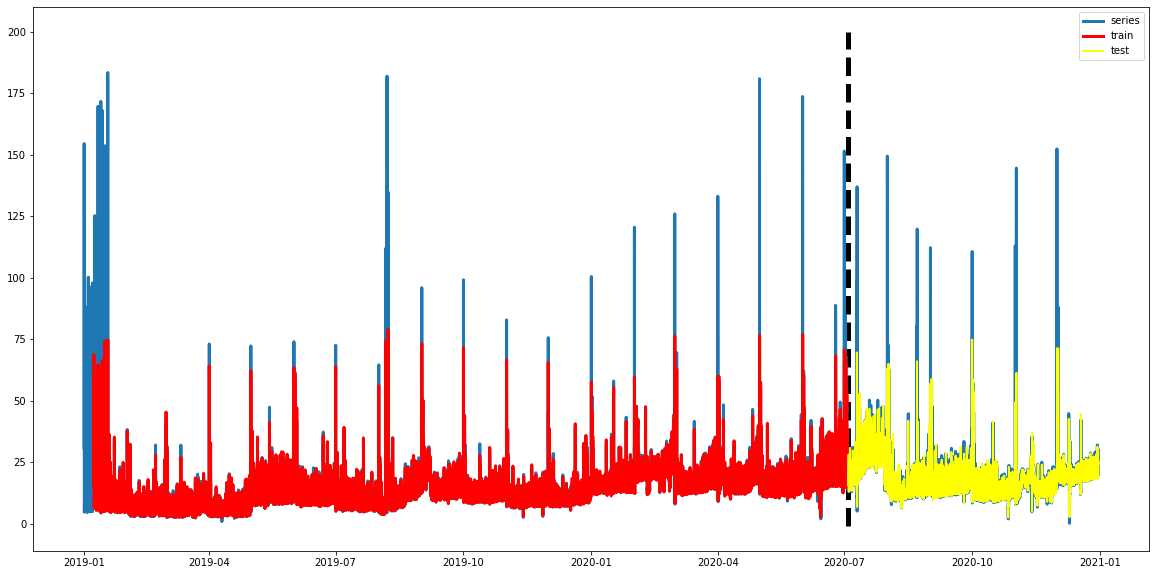

In [81]:
plt.figure(figsize=(20,10))
plt.plot(series,linewidth=3,label='series')
plt.vlines(X.index[-1440*6],-1,200,linestyles = "dashed",linewidth=5)
plt.plot(X.index[:-1440*6],trainpre1,color='red',label='train',linewidth=3)
plt.plot(X.index[-1440*6:],preds1,color='yellow',label='test', linewidth=2)
plt.legend()
plt.show()